# Maths Corsica 
## Carthographie & Géométrie (niveau troisième)

### Vérifions que le fichier est présent


In [1]:
from typing import Any
import os

RAW_FRANCE_DIR = "data/raw/geojson/france"
PROCESSED_CORSICA_DIR = "data/processed/corsica"

# Ensure processed output directory exists
os.makedirs(PROCESSED_CORSICA_DIR, exist_ok=True)

print("raw files in:", RAW_FRANCE_DIR)
print(os.listdir(RAW_FRANCE_DIR))

raw files in: data/raw/geojson/france
['region.json']


In [2]:
### Lisons le fichier geojson

import json


def read_geojson_from_filepath(filepath) -> dict:
    with open(filepath, 'r') as file:
        geojson_string = file.read()
        return json.loads(geojson_string)


filepath = f"{RAW_FRANCE_DIR}/region.json"
geojson = read_geojson_from_filepath(filepath)

print(geojson.keys())
print(geojson["type"])
# 

dict_keys(['type', 'features'])
FeatureCollection


In [3]:
# ===== Output helpers: precise file naming and saving =====
from datetime import datetime


def build_output_filename(base: str, suffix: str, ext: str) -> str:
    """Create a precise, deterministic filename.
    Example: corsica_map_grid10km_800x1200_v1.svg
    """
    if ext.startswith("."):
        ext = ext[1:]
    return f"{base}_{suffix}.{ext}"


def save_matplotlib_figure(fig, name_base: str, grid_km=None, width_px=None, height_px=None):
    parts = []
    if grid_km is not None:
        parts.append(f"grid{grid_km}km")
    if width_px and height_px:
        parts.append(f"{width_px}x{height_px}")
    suffix = "_".join(parts) if parts else "v1"

    png_path = os.path.join(PROCESSED_CORSICA_DIR, build_output_filename(name_base, suffix, "png"))
    svg_path = os.path.join(PROCESSED_CORSICA_DIR, build_output_filename(name_base, suffix, "svg"))

    # Save high-quality PNG and SVG
    fig.savefig(png_path, dpi=200, bbox_inches="tight")
    fig.savefig(svg_path, format="svg", bbox_inches="tight")
    print("saved:", png_path)
    print("saved:", svg_path)


def save_svg_text(svg_text: str, name_base: str, grid_km: int, width: int, height: int):
    suffix = f"grid{grid_km}km_{width}x{height}"
    svg_path = os.path.join(PROCESSED_CORSICA_DIR, build_output_filename(name_base, suffix, "svg"))
    with open(svg_path, "w") as f:
        f.write(svg_text)
    print("saved:", svg_path)



In [4]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import numpy as np

def extract_corsica_data(geojson_data, region_name="Corse"):
    """Extract only Corsica data from the GeoJSON"""
    corsica_features = []
    for feature in geojson_data['features']:
        props = feature.get('properties', {})
        name = props.get('nom', props.get('name', ''))
        if name == region_name:
            corsica_features.append(feature)
    
    return {
        "type": "FeatureCollection",
        "features": corsica_features
    }

def extract_polygon_coordinates(feature):
    """Extract coordinates from a polygon feature, handling MultiPolygon properly"""
    geometry = feature['geometry']
    if geometry['type'] == 'Polygon':
        # Return the outer ring (first coordinate array)
        return [geometry['coordinates'][0]]
    elif geometry['type'] == 'MultiPolygon':
        # Return each polygon's outer ring separately
        polygons = []
        for polygon in geometry['coordinates']:
            polygons.append(polygon[0])  # Take outer ring of each polygon
        return polygons
    return []

def create_beautiful_corsica_map(geojson_data, title="Corsica - Cartographie & Géométrie"):
    """Create a beautiful map visualization of Corsica with correct proportions"""
    
    # First, get the coordinate bounds to calculate proper aspect ratio
    all_coords = []
    for feature in geojson_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    if not all_coords:
        print("No valid coordinates found!")
        return
    
    # Calculate bounds
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    
    # Calculate the center latitude for aspect ratio correction
    center_lat = (min_lat + max_lat) / 2
    
    # Correct aspect ratio: at latitude ~42°N, 1° longitude ≈ cos(42°) * 1° latitude
    lat_correction = np.cos(np.radians(center_lat))
    
    # Calculate the actual geographic dimensions
    width_deg = max_lon - min_lon
    height_deg = max_lat - min_lat
    
    # Determine figure size based on geographic proportions
    # Corsica is roughly taller than it is wide
    if height_deg > width_deg * lat_correction:
        # Height-dominant: fix height, adjust width
        fig_height = 12
        fig_width = fig_height * (width_deg * lat_correction) / height_deg
        fig_width = max(fig_width, 8)  # Minimum width
    else:
        # Width-dominant: fix width, adjust height  
        fig_width = 10
        fig_height = fig_width * height_deg / (width_deg * lat_correction)
        fig_height = max(fig_height, 8)  # Minimum height
    
    # Set up the figure with calculated proportions
    plt.style.use('default')
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
    # White background everywhere
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    print(f"Corsica dimensions: {width_deg:.3f}° × {height_deg:.3f}°")
    print(f"Figure size: {fig_width:.1f} × {fig_height:.1f} inches")
    print(f"Aspect ratio correction factor: {lat_correction:.3f}")
    
    # Beautiful color palette for Corsica
    corsica_colors = ['#2E8B57', '#3CB371', '#20B2AA', '#4682B4', '#6495ED']  # Sea green to blue tones
    
    patches_list = []
    feature_names = []
    
    # Process each feature in the GeoJSON
    for i, feature in enumerate(geojson_data['features']):
        polygon_coords_list = extract_polygon_coordinates(feature)
        
        for j, coords in enumerate(polygon_coords_list):
            if coords and len(coords) > 2:  # Ensure we have valid coordinates
                try:
                    # Convert coordinates to numpy array
                    coords_array = np.array(coords)
                    
                    # Create polygon patch
                    polygon = patches.Polygon(coords_array, closed=True)
                    patches_list.append(polygon)
                    
                    # Get feature name
                    props = feature.get('properties', {})
                    name = props.get('nom', props.get('name', f'Feature {i+1}'))
                    if len(polygon_coords_list) > 1:
                        name = f"{name} - Part {j+1}"
                    feature_names.append(name)
                except Exception as e:
                    print(f"Error processing polygon {j} of feature {i}: {e}")
                    continue
    
    if not patches_list:
        print("No valid polygons found!")
        return
    
    # Create patch collection with beautiful colors
    patch_collection = PatchCollection(patches_list, alpha=0.85)
    
    # Set colors - use Corsica-themed colors
    patch_colors = [corsica_colors[i % len(corsica_colors)] for i in range(len(patches_list))]
    patch_collection.set_facecolors(patch_colors)
    patch_collection.set_edgecolors('#1C3A3A')  # Darker borders for better definition
    patch_collection.set_linewidths(2.0)
    
    # Add patches to axes
    ax.add_collection(patch_collection)
    
    # CRITICAL: Set the correct aspect ratio for geographic data
    # This ensures 1° longitude appears proportional to 1° latitude at this latitude
    ax.set_aspect(1.0 / lat_correction)
    
    # Set limits with proper padding
    x_padding = width_deg * 0.05
    y_padding = height_deg * 0.05
    ax.set_xlim(min_lon - x_padding, max_lon + x_padding)
    ax.set_ylim(min_lat - y_padding, max_lat + y_padding)
    
    # Axis labels only (no figure title)
    ax.set_title("")
    ax.set_xlabel('Longitude (°)', fontsize=16, color='#2F4F4F', fontweight='medium')
    ax.set_ylabel('Latitude (°)', fontsize=16, color='#2F4F4F', fontweight='medium')
    
    # Enhanced grid
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='#708090')
    ax.set_axisbelow(True)  # Put grid behind the map
    
    # Style the spines
    for spine in ax.spines.values():
        spine.set_color('#2F4F4F')
        spine.set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Enhance tick labels
    ax.tick_params(colors='#2F4F4F', labelsize=12)
    
    # Add coordinate information
    # Remove legend-like text and north arrow per requirements
    
    plt.tight_layout()
    # Save to processed with precise name
    width_px = int(fig.get_figwidth() * 200)
    height_px = int(fig.get_figheight() * 200)
    save_matplotlib_figure(fig, name_base="corsica_map", width_px=width_px, height_px=height_px)
    plt.show()
    
    return fig, ax

Found 1 Corsica feature(s)
- Corse (code: 94)
Corsica dimensions: 1.019° × 1.650°
Figure size: 8.0 × 12.0 inches
Aspect ratio correction factor: 0.741
saved: data/processed/corsica/corsica_map_1600x2400.png
saved: data/processed/corsica/corsica_map_1600x2400.svg


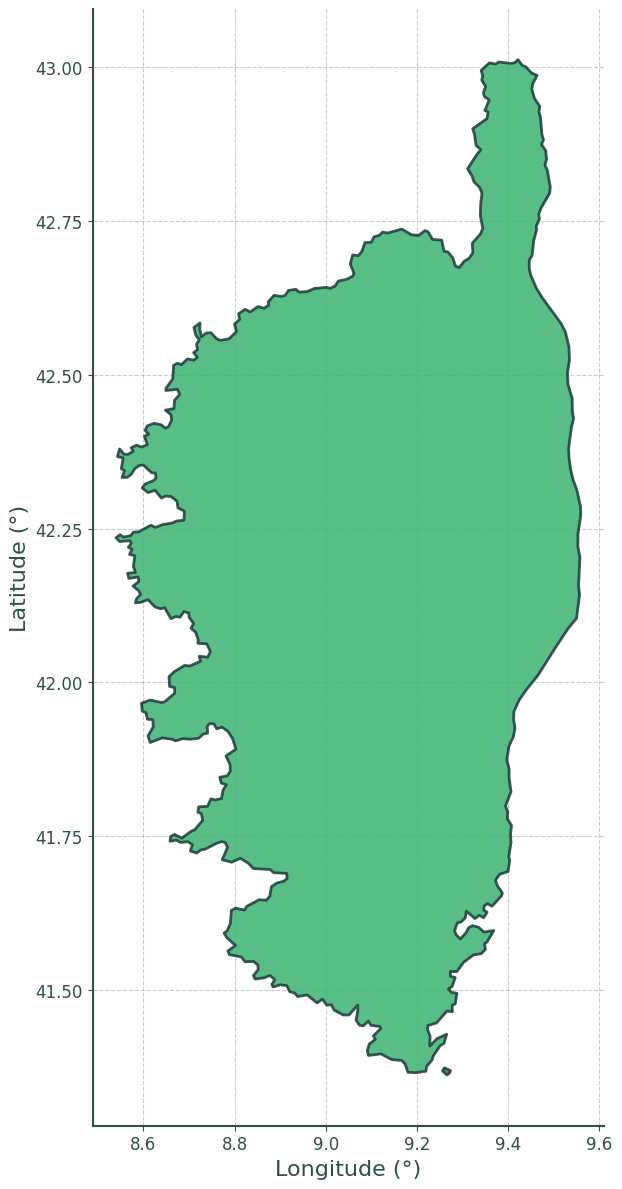

(<Figure size 800x1200 with 1 Axes>,
 <Axes: xlabel='Longitude (°)', ylabel='Latitude (°)'>)

In [5]:
# Extract only Corsica from the GeoJSON data
corsica_data = extract_corsica_data(geojson, "Corse")

print(f"Found {len(corsica_data['features'])} Corsica feature(s)")
for feature in corsica_data['features']:
    props = feature.get('properties', {})
    print(f"- {props.get('nom', 'Unknown')} (code: {props.get('code', 'N/A')})")

# Create the beautiful Corsica map
create_beautiful_corsica_map(corsica_data)

In [6]:
# Calculs géométriques sur la Corse
# Geometric calculations for Corsica

def calculate_corsica_metrics(corsica_data):
    """Calculate accurate geometric metrics for educational purposes"""
    
    if not corsica_data['features']:
        print("Aucune donnée trouvée pour la Corse")
        return
    
    feature = corsica_data['features'][0]  # Get the Corsica feature
    polygon_coords_list = extract_polygon_coordinates(feature)
    
    print("=== ANALYSES GÉOMÉTRIQUES DE LA CORSE ===\n")
    
    def haversine_distance(lon1, lat1, lon2, lat2):
        """Calculate the great circle distance between two points on Earth (in km)"""
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        
        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        # Radius of earth in kilometers
        r = 6371
        return c * r
    
    total_area_approx = 0
    
    for i, coords in enumerate(polygon_coords_list):
        if not coords:
            continue
            
        coords_array = np.array(coords)
        
        # Calculate bounding box
        min_lon, min_lat = coords_array.min(axis=0)
        max_lon, max_lat = coords_array.max(axis=0)
        center_lat = (min_lat + max_lat) / 2
        
        print(f"Polygone {i+1}:")
        print(f"  • Coordonnées extrêmes:")
        print(f"    - Longitude: {min_lon:.4f}° à {max_lon:.4f}° E")
        print(f"    - Latitude: {min_lat:.4f}° à {max_lat:.4f}° N")
        print(f"    - Centre approximatif: {(min_lon + max_lon)/2:.4f}° E, {center_lat:.4f}° N")
        
        # Calculate accurate dimensions using Haversine formula
        width_km = haversine_distance(min_lon, center_lat, max_lon, center_lat)
        height_km = haversine_distance((min_lon + max_lon)/2, min_lat, (min_lon + max_lon)/2, max_lat)
        
        print(f"  • Dimensions géographiques réelles:")
        print(f"    - Largeur maximale: {width_km:.1f} km")
        print(f"    - Hauteur maximale: {height_km:.1f} km")
        print(f"    - Ratio hauteur/largeur: {height_km/width_km:.2f}")
        
        # Calculate number of vertices
        num_vertices = len(coords)
        print(f"  • Nombre de sommets du polygone: {num_vertices}")
        
        # Calculate more accurate perimeter using Haversine
        perimeter_km = 0
        for j in range(len(coords)):
            p1 = coords_array[j]
            p2 = coords_array[(j + 1) % len(coords)]
            dist = haversine_distance(p1[0], p1[1], p2[0], p2[1])
            perimeter_km += dist
        
        print(f"  • Périmètre géographique: {perimeter_km:.1f} km")
        
        # Approximate area using shoelace formula (rough approximation)
        # Convert to projected coordinates for area calculation
        lat_correction = np.cos(np.radians(center_lat))
        
        # Simple area calculation (very approximate)
        area_deg2 = 0
        for j in range(len(coords)):
            x1, y1 = coords_array[j]
            x2, y2 = coords_array[(j + 1) % len(coords)]
            area_deg2 += x1 * y2 - x2 * y1
        area_deg2 = abs(area_deg2) / 2
        
        # Convert to km² (very rough approximation)
        area_km2 = area_deg2 * (111 * lat_correction) * 111
        total_area_approx += area_km2
        
        print(f"  • Superficie approximative: {area_km2:.0f} km²")
        print()
    
    print(f"📊 RÉSUMÉ GÉOMÉTRIQUE:")
    print(f"   • Superficie totale approximative: {total_area_approx:.0f} km²")
    print(f"   • Référence: La Corse fait environ 8 722 km² (donnée officielle)")
    print(f"   • Notre approximation: {(total_area_approx/8722)*100:.1f}% de la valeur réelle")
    print(f"   • Note: Les calculs sont approximatifs à des fins pédagogiques\n")

# Run the calculations
calculate_corsica_metrics(corsica_data)


=== ANALYSES GÉOMÉTRIQUES DE LA CORSE ===

Polygone 1:
  • Coordonnées extrêmes:
    - Longitude: 9.2559° à 9.2737° E
    - Latitude: 41.3622° à 41.3737° N
    - Centre approximatif: 9.2648° E, 41.3679° N
  • Dimensions géographiques réelles:
    - Largeur maximale: 1.5 km
    - Hauteur maximale: 1.3 km
    - Ratio hauteur/largeur: 0.86
  • Nombre de sommets du polygone: 6
  • Périmètre géographique: 4.0 km
  • Superficie approximative: 1 km²

Polygone 2:
  • Coordonnées extrêmes:
    - Longitude: 8.5401° à 9.5592° E
    - Latitude: 41.3659° à 43.0117° N
    - Centre approximatif: 9.0497° E, 42.1888° N
  • Dimensions géographiques réelles:
    - Largeur maximale: 84.0 km
    - Hauteur maximale: 183.0 km
    - Ratio hauteur/largeur: 2.18
  • Nombre de sommets du polygone: 476
  • Périmètre géographique: 671.3 km
  • Superficie approximative: 8671 km²

📊 RÉSUMÉ GÉOMÉTRIQUE:
   • Superficie totale approximative: 8672 km²
   • Référence: La Corse fait environ 8 722 km² (donnée officielle)


In [7]:
# ===== EXERCICES POUR TROISIÈME ET SECONDE =====
# Educational exercises for 9th and 10th grade

def create_educational_exercises_list():
    """List all available exercises with this Corsica data"""
    
    print("🎓 EXERCICES DISPONIBLES AVEC LES DONNÉES DE LA CORSE")
    print("=" * 60)
    
    print("\n📐 NIVEAU TROISIÈME (9ème année):")
    print("1. 📏 Mesures et proportions")
    print("   • Calcul de distances à l'aide d'échelles")
    print("   • Conversion degrés ↔ kilomètres")
    print("   • Calcul de périmètres approximatifs")
    
    print("\n2. 🔲 Calcul de superficie par quadrillage")
    print("   • Méthode des carrés pour approximer l'aire")
    print("   • Comptage de carrés entiers/partiels")
    print("   • Comparaison avec la superficie officielle")
    
    print("\n3. 📊 Coordonnées et repères")
    print("   • Lecture de coordonnées géographiques")
    print("   • Placement de points sur une carte")
    print("   • Calcul de distances entre villes")
    
    print("\n4. 📐 Géométrie des polygones")
    print("   • Comptage des sommets du contour")
    print("   • Notion de polygone complexe")
    print("   • Angles et directions (Nord, Sud, Est, Ouest)")
    
    print("\n📈 NIVEAU SECONDE (10ème année):")
    print("5. 🧮 Trigonométrie appliquée")
    print("   • Correction de latitude (cosinus)")
    print("   • Calculs d'angles de navigation")
    print("   • Projections cartographiques")
    
    print("\n6. 📊 Fonctions et modélisation")
    print("   • Fonction distance de Haversine")
    print("   • Modélisation de la courbure terrestre")
    print("   • Approximations polynomiales")
    
    print("\n7. 📐 Géométrie analytique")
    print("   • Équations de droites (méridiens/parallèles)")
    print("   • Calculs vectoriels pour les déplacements")
    print("   • Optimisation de trajets")
    
    print("\n8. 📈 Statistiques géographiques")
    print("   • Analyse des coordonnées (moyenne, écart-type)")
    print("   • Distribution des points du littoral")
    print("   • Corrélations géographiques")

# Display the list
create_educational_exercises_list()


🎓 EXERCICES DISPONIBLES AVEC LES DONNÉES DE LA CORSE

📐 NIVEAU TROISIÈME (9ème année):
1. 📏 Mesures et proportions
   • Calcul de distances à l'aide d'échelles
   • Conversion degrés ↔ kilomètres
   • Calcul de périmètres approximatifs

2. 🔲 Calcul de superficie par quadrillage
   • Méthode des carrés pour approximer l'aire
   • Comptage de carrés entiers/partiels
   • Comparaison avec la superficie officielle

3. 📊 Coordonnées et repères
   • Lecture de coordonnées géographiques
   • Placement de points sur une carte
   • Calcul de distances entre villes

4. 📐 Géométrie des polygones
   • Comptage des sommets du contour
   • Notion de polygone complexe
   • Angles et directions (Nord, Sud, Est, Ouest)

📈 NIVEAU SECONDE (10ème année):
5. 🧮 Trigonométrie appliquée
   • Correction de latitude (cosinus)
   • Calculs d'angles de navigation
   • Projections cartographiques

6. 📊 Fonctions et modélisation
   • Fonction distance de Haversine
   • Modélisation de la courbure terrestre
   • App

In [8]:
# ===== SVG VERSION OF THE GRID VISUALIZATION (BASIC) =====
# Baseline simplified SVG (keep proportions fixed earlier), no legend

def create_corsica_grid_svg(corsica_data, grid_size_km=10):
    """
    Create an SVG version of the grid overlay on Corsica for area calculation exercises
    Uses DaisyUI-compatible CSS variables for colors and improved styling
    """
    
    # Get Corsica bounds
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # Convert grid size to degrees
    lat_correction = np.cos(np.radians(center_lat))
    grid_size_deg_lat = grid_size_km / 111
    grid_size_deg_lon = grid_size_km / (111 * lat_correction)
    
    # Create grid ranges
    padding = 0.02
    lon_range = np.arange(min_lon - padding, max_lon + padding + grid_size_deg_lon, grid_size_deg_lon)
    lat_range = np.arange(min_lat - padding, max_lat + padding + grid_size_deg_lat, grid_size_deg_lat)
    
    # Calculate SVG dimensions and viewBox
    width_deg = max_lon - min_lon + 2 * padding
    height_deg = max_lat - min_lat + 2 * padding
    
    # Scale factor for SVG (larger = more detail)
    scale_factor = 800 / max(width_deg, height_deg)
    svg_width = int(width_deg * scale_factor)
    svg_height = int(height_deg * scale_factor)
    
    # Create path for Corsica polygons for point-in-polygon tests
    from matplotlib.path import Path
    corsica_paths = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                path = Path(coords)
                corsica_paths.append(path)
    
    # Count different types of squares and collect their info
    total_squares = 0
    full_squares = 0
    partial_squares = 0
    empty_squares = 0
    
    square_elements = []
    corsica_polygons = []
    
    # Process squares
    for i in range(len(lon_range) - 1):
        for j in range(len(lat_range) - 1):
            total_squares += 1
            
            # Define square corners
            lon1, lon2 = lon_range[i], lon_range[i + 1]
            lat1, lat2 = lat_range[j], lat_range[j + 1]
            
            # Convert to SVG coordinates (flip Y axis)
            x1 = (lon1 - (min_lon - padding)) * scale_factor
            y1 = svg_height - (lat2 - (min_lat - padding)) * scale_factor
            x2 = (lon2 - (min_lon - padding)) * scale_factor
            y2 = svg_height - (lat1 - (min_lat - padding)) * scale_factor
            
            # Test square corners and center for intersection with Corsica
            corners = [
                (lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2),
                ((lon1 + lon2)/2, (lat1 + lat2)/2)  # center
            ]
            
            inside_count = 0
            for point in corners:
                for path in corsica_paths:
                    if path.contains_point(point):
                        inside_count += 1
                        break
            
            # Classify square and create SVG element
            if inside_count == 5:  # All points inside
                square_type = 'full'
                full_squares += 1
                css_class = 'full-square'
            elif inside_count > 0:  # Some points inside
                square_type = 'partial'
                partial_squares += 1
                css_class = 'partial-square'
            else:  # No points inside
                square_type = 'empty'
                empty_squares += 1
                continue  # Don't add empty squares to SVG
            
            # Create square rectangle element
            square_elements.append(f'''
                <rect x="{x1:.1f}" y="{y1:.1f}" 
                      width="{x2-x1:.1f}" height="{y2-y1:.1f}" 
                      class="{css_class}" />''')
    
    # Create Corsica polygon paths
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                # Convert coordinates to SVG path
                path_data = "M "
                for i, (lon, lat) in enumerate(coords):
                    x = (lon - (min_lon - padding)) * scale_factor
                    y = svg_height - (lat - (min_lat - padding)) * scale_factor
                    if i == 0:
                        path_data += f"{x:.1f},{y:.1f} "
                    else:
                        path_data += f"L {x:.1f},{y:.1f} "
                path_data += "Z"
                
                corsica_polygons.append(f'<path d="{path_data}" class="corsica-polygon" />')
    
    # Create grid lines
    grid_lines = []
    
    # Vertical lines (longitude)
    for lon in lon_range:
        x = (lon - (min_lon - padding)) * scale_factor
        grid_lines.append(f'<line x1="{x:.1f}" y1="0" x2="{x:.1f}" y2="{svg_height}" class="grid-line" />')
    
    # Horizontal lines (latitude)  
    for lat in lat_range:
        y = svg_height - (lat - (min_lat - padding)) * scale_factor
        grid_lines.append(f'<line x1="0" y1="{y:.1f}" x2="{svg_width}" y2="{y:.1f}" class="grid-line" />')
    
    # Calculate area estimation
    area_per_square = grid_size_km * grid_size_km
    estimated_area_min = full_squares * area_per_square
    estimated_area_max = (full_squares + partial_squares) * area_per_square
    estimated_area_avg = (estimated_area_min + estimated_area_max) / 2
    
    # Create SVG content (legend removed)
    svg_content = f'''<svg width="{svg_width}" height="{svg_height}" viewBox="0 0 {svg_width} {svg_height}" 
         xmlns="http://www.w3.org/2000/svg">
    
    <!-- CSS Styles using DaisyUI-compatible variables -->
    <style>
        <![CDATA[
        .corsica-polygon {{
            fill: var(--color-success, #36d399);
            stroke: var(--color-success-content, #003a2a);
            stroke-width: 2;
            opacity: 0.8;
        }}
        
        .full-square {{
            fill: var(--color-info, #3abff8);
            stroke: var(--color-error, #f87272);
            stroke-width: 0.8;
            opacity: 0.4;
        }}
        
        .partial-square {{
            fill: var(--color-warning, #fbbd23);
            stroke: var(--color-error, #f87272);
            stroke-width: 0.8;
            opacity: 0.4;
        }}
        
        .grid-line {{
            stroke: var(--color-error, #f87272);
            stroke-width: 1.2;
            stroke-dasharray: 4,2;
            opacity: 0.8;
        }}
        ]]>
    </style>
    
    <!-- Grid lines (background) -->
    {''.join(grid_lines)}
    
    <!-- Squares -->
    {''.join(square_elements)}
    
    <!-- Corsica polygons (foreground) -->
    {''.join(corsica_polygons)}
    
</svg>'''
    
    # Display the SVG
    from IPython.display import SVG, display
    display(SVG(svg_content))

    # Save SVG to processed with precise name
    save_svg_text(svg_text=svg_content, name_base="corsica_grid_svg_basic", grid_km=grid_size_km, width=svg_width, height=svg_height)
    
    # Print results
    print(f"\n📊 RÉSULTATS DU QUADRILLAGE (SVG VERSION):")
    print(f"   🔲 Taille d'un carré: {grid_size_km} km × {grid_size_km} km = {area_per_square} km²")
    print(f"   📈 Total des carrés analysés: {total_squares}")
    print(f"   🟦 Carrés entièrement dans la Corse: {full_squares}")
    print(f"   🟧 Carrés partiellement dans la Corse: {partial_squares}")
    print(f"   ⬜ Carrés vides: {empty_squares}")
    print(f"\n📏 ESTIMATION DE LA SUPERFICIE:")
    print(f"   • Estimation minimale: {estimated_area_min:,} km² (carrés entiers seulement)")
    print(f"   • Estimation maximale: {estimated_area_max:,} km² (entiers + partiels)")
    print(f"   • Estimation moyenne: {estimated_area_avg:,.0f} km²")
    print(f"   • Superficie officielle: 8,722 km²")
    print(f"   • Erreur relative: {abs(estimated_area_avg - 8722)/8722*100:.1f}%")
    
    return {
        'svg_content': svg_content,
        'grid_size_km': grid_size_km,
        'full_squares': full_squares,
        'partial_squares': partial_squares,
        'estimated_area': estimated_area_avg,
        'svg_width': svg_width,
        'svg_height': svg_height
    }

# Create the SVG version of the grid exercise
print("🎯 EXERCICE SVG: Calcul de superficie par quadrillage")
print("=" * 55)
svg_results = create_corsica_grid_svg(corsica_data, grid_size_km=10)


🎯 EXERCICE SVG: Calcul de superficie par quadrillage


saved: data/processed/corsica/corsica_grid_svg_basic_grid10km_501x800.svg

📊 RÉSULTATS DU QUADRILLAGE (SVG VERSION):
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%


🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_2800x3200.png
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_2800x3200.svg


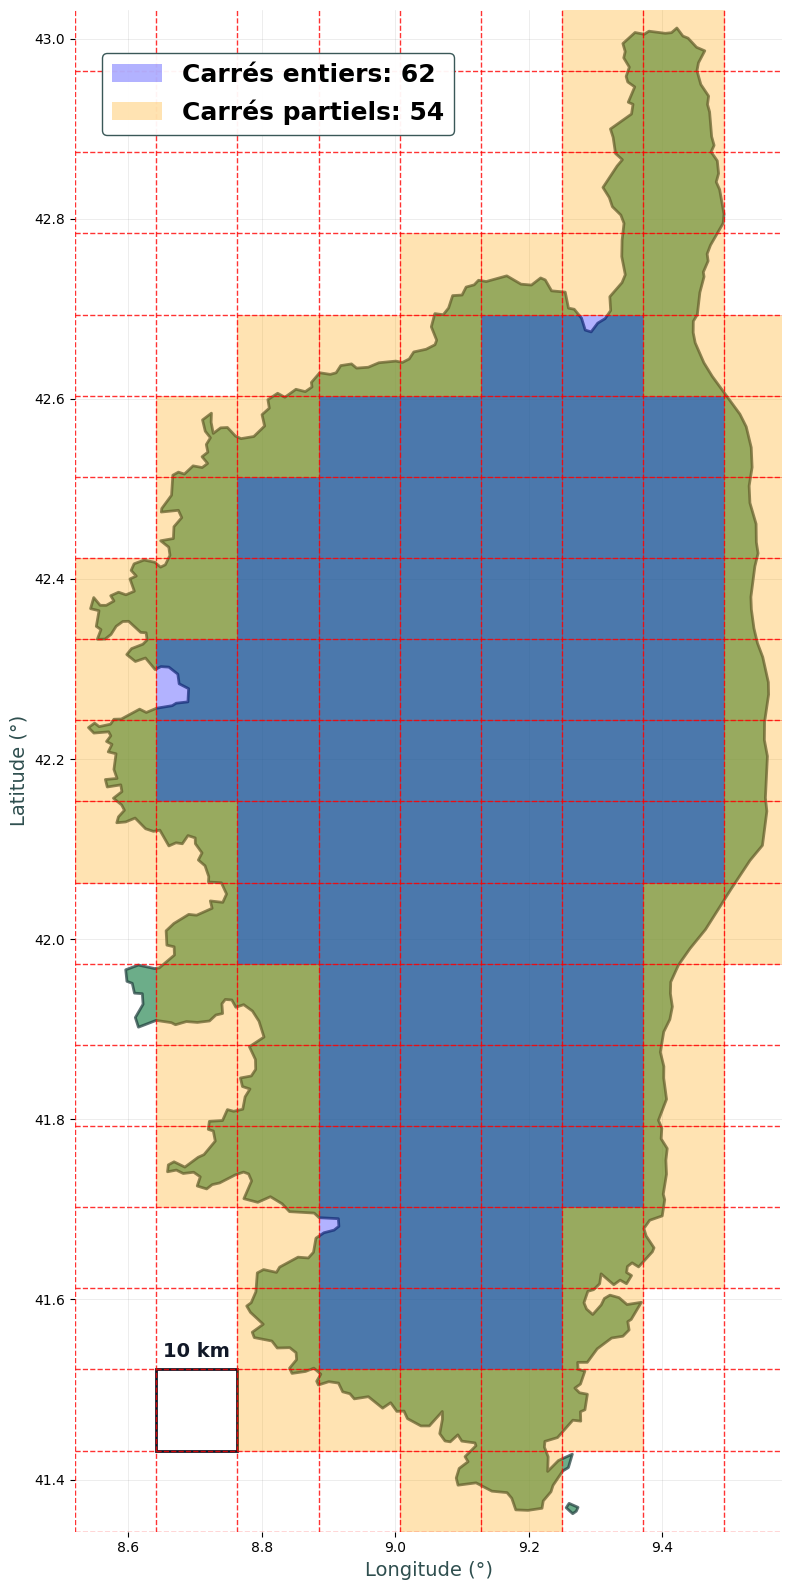


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%

🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_2800x3200.png
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_2800x3200.svg


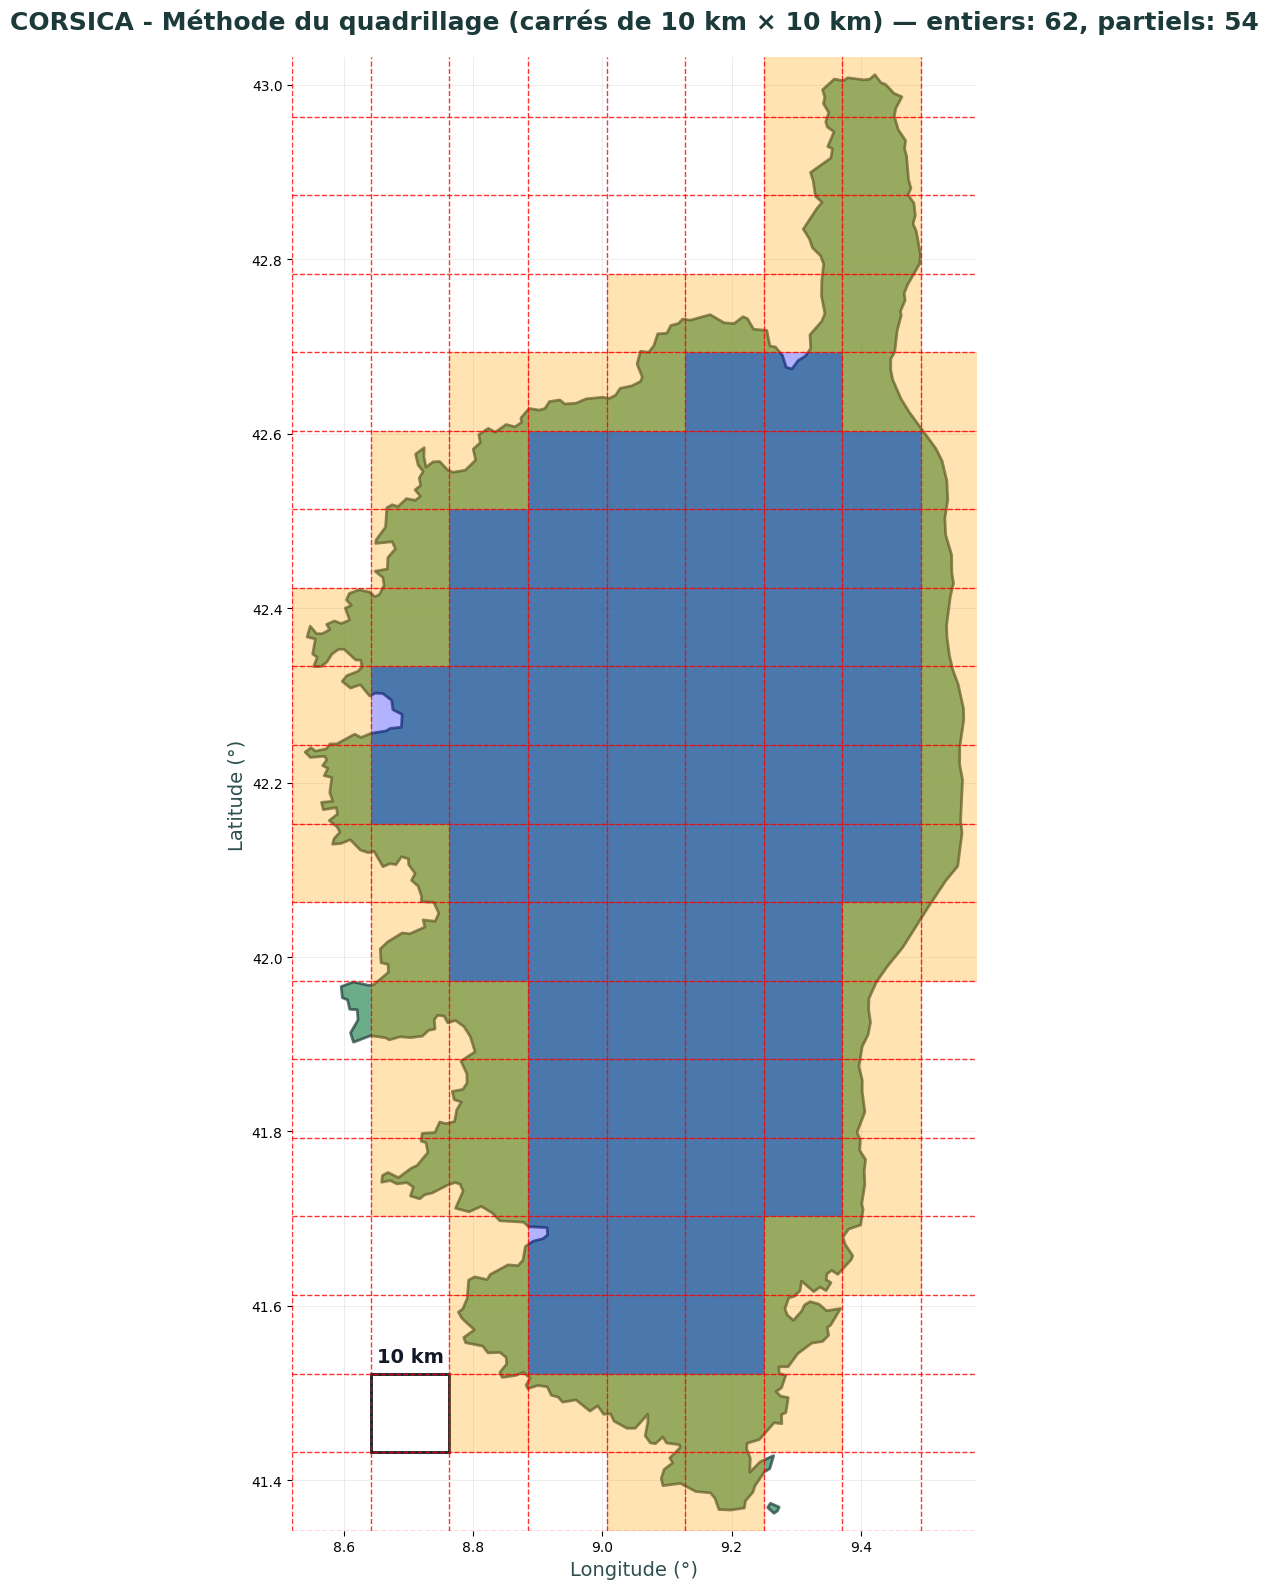


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%


In [9]:
# ===== MÉTHODE DU QUADRILLAGE POUR CALCULER LA SUPERFICIE =====
# Square grid method for area calculation - Perfect for Troisième level

def create_corsica_grid_exercise(corsica_data, grid_size_km=5, for_svg_title_counts=False):
    """
    Create a grid overlay on Corsica for area calculation exercises
    Students will count squares to estimate the area
    """
    
    # Get Corsica bounds
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # Convert grid size to degrees
    # 1 degree ≈ 111 km, but adjust for latitude
    lat_correction = np.cos(np.radians(center_lat))
    grid_size_deg_lat = grid_size_km / 111
    grid_size_deg_lon = grid_size_km / (111 * lat_correction)
    
    # Create grid
    padding = 0.02  # Small padding
    lon_range = np.arange(min_lon - padding, max_lon + padding + grid_size_deg_lon, grid_size_deg_lon)
    lat_range = np.arange(min_lat - padding, max_lat + padding + grid_size_deg_lat, grid_size_deg_lat)
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 16))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Draw Corsica
    corsica_color = '#2E8B57'  # Sea green
    patches_list = []
    
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                coords_array = np.array(coords)
                polygon = patches.Polygon(coords_array, closed=True)
                patches_list.append(polygon)
    
    if patches_list:
        patch_collection = PatchCollection(patches_list, alpha=0.7)
        patch_collection.set_facecolors(corsica_color)
        patch_collection.set_edgecolors('#1C3A3A')
        patch_collection.set_linewidths(2)
        ax.add_collection(patch_collection)
    
    # Draw the grid
    grid_lines = []
    
    # Vertical lines (longitude)
    for lon in lon_range:
        line = plt.Line2D([lon, lon], [min_lat - padding, max_lat + padding], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
    
    # Add a simple 10km scale square (second column, second row)
    try:
        lon1, lon2 = lon_range[1], lon_range[2]
        lat1, lat2 = lat_range[1], lat_range[2]
        scale_square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1,
                                         facecolor='none', edgecolor='#111827', linewidth=2)
        ax.add_patch(scale_square)
        ax.text(lon1 + (lon2-lon1)/2, lat2 + (lat2-lat1)*0.1,
                f"{grid_size_km} km",
                ha='center', va='bottom', fontsize=14, fontweight='bold', color='#111827')
    except Exception:
        pass
    
    # Horizontal lines (latitude)  
    for lat in lat_range:
        line = plt.Line2D([min_lon - padding, max_lon + padding], [lat, lat], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
    
    # Count squares that intersect with Corsica
    from matplotlib.path import Path
    
    # Create path from Corsica polygon for point-in-polygon tests
    corsica_paths = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                path = Path(coords)
                corsica_paths.append(path)
    
    # Count different types of squares
    total_squares = 0
    full_squares = 0
    partial_squares = 0
    empty_squares = 0
    
    square_info = []
    
    for i in range(len(lon_range) - 1):
        for j in range(len(lat_range) - 1):
            total_squares += 1
            
            # Define square corners
            lon1, lon2 = lon_range[i], lon_range[i + 1]
            lat1, lat2 = lat_range[j], lat_range[j + 1]
            
            # Test square corners and center
            corners = [
                (lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2),
                ((lon1 + lon2)/2, (lat1 + lat2)/2)  # center
            ]
            
            # Check how many points are inside Corsica
            inside_count = 0
            for point in corners:
                for path in corsica_paths:
                    if path.contains_point(point):
                        inside_count += 1
                        break
            
            # Classify square
            if inside_count == 5:  # All points inside
                square_type = 'full'
                full_squares += 1
                color = 'blue'
                alpha = 0.3
            elif inside_count > 0:  # Some points inside
                square_type = 'partial'
                partial_squares += 1
                color = 'orange'
                alpha = 0.3
            else:  # No points inside
                square_type = 'empty'
                empty_squares += 1
                continue  # Don't draw empty squares
            
            # Draw square with color coding
            square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1, 
                                     facecolor=color, alpha=alpha, edgecolor='red', linewidth=0.5)
            ax.add_patch(square)
            
            # Store info for exercise
            center_lon = (lon1 + lon2) / 2
            center_lat = (lat1 + lat2) / 2
            square_info.append({
                'id': f'{i}-{j}',
                'center': (center_lon, center_lat),
                'type': square_type,
                'corners': [(lon1, lat1), (lon2, lat2)]
            })
    
    # Set proper aspect ratio and limits
    ax.set_aspect(1.0 / lat_correction)
    ax.set_xlim(min_lon - padding, max_lon + padding)
    ax.set_ylim(min_lat - padding, max_lat + padding)
    
    # Styling
    if for_svg_title_counts:
        ax.set_title(f'CORSICA - Méthode du quadrillage (carrés de {grid_size_km} km × {grid_size_km} km) — entiers: {full_squares}, partiels: {partial_squares}',
                     fontsize=18, fontweight='bold', pad=20, color='#1C3A3A')
    else:
        ax.set_title("")
    ax.set_xlabel('Longitude (°)', fontsize=14, color='#2F4F4F')
    ax.set_ylabel('Latitude (°)', fontsize=14, color='#2F4F4F')
    
    # Optional legend: if not for_svg_title_counts, draw a BIG legend top-left
    if not for_svg_title_counts:
        legend_elements = [
            patches.Patch(facecolor='blue', alpha=0.3, label=f'Carrés entiers: {full_squares}'),
            patches.Patch(facecolor='orange', alpha=0.3, label=f'Carrés partiels: {partial_squares}'),
        ]
        leg = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98),
                         frameon=True, framealpha=0.95, facecolor='white', edgecolor='#2F4F4F',
                         fontsize=18)
        for text in leg.get_texts():
            text.set_fontweight('bold')
    
    # Grid and styling
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    # Save to processed with precise name
    width_px = int(fig.get_figwidth() * 200)
    height_px = int(fig.get_figheight() * 200)
    save_matplotlib_figure(fig, name_base="corsica_grid_matplotlib", grid_km=grid_size_km, width_px=width_px, height_px=height_px)
    plt.show()

    # A simple 10km-scale square placed near top-left inside plot for clarity (not saved in PNG legend version)
    # We add it earlier to the axes as a patch if desired; here we keep PNG unchanged and only include in title/legend explanatory text.

    
    # Calculate area estimation
    area_per_square = grid_size_km * grid_size_km
    estimated_area_min = full_squares * area_per_square
    estimated_area_max = (full_squares + partial_squares) * area_per_square
    estimated_area_avg = (estimated_area_min + estimated_area_max) / 2
    
    print(f"\n📊 RÉSULTATS DU QUADRILLAGE:")
    print(f"   🔲 Taille d'un carré: {grid_size_km} km × {grid_size_km} km = {area_per_square} km²")
    print(f"   📈 Total des carrés analysés: {total_squares}")
    print(f"   🟦 Carrés entièrement dans la Corse: {full_squares}")
    print(f"   🟧 Carrés partiellement dans la Corse: {partial_squares}")
    print(f"   ⬜ Carrés vides: {empty_squares}")
    print(f"\n📏 ESTIMATION DE LA SUPERFICIE:")
    print(f"   • Estimation minimale: {estimated_area_min:,} km² (carrés entiers seulement)")
    print(f"   • Estimation maximale: {estimated_area_max:,} km² (entiers + partiels)")
    print(f"   • Estimation moyenne: {estimated_area_avg:,.0f} km²")
    print(f"   • Superficie officielle: 8,722 km²")
    print(f"   • Erreur relative: {abs(estimated_area_avg - 8722)/8722*100:.1f}%")
    
    return {
        'grid_size_km': grid_size_km,
        'full_squares': full_squares,
        'partial_squares': partial_squares,
        'estimated_area': estimated_area_avg,
        'square_info': square_info
    }

# Create the grid exercise for PNG (legend top-left, no title)
print("🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)")
print("=" * 60)
grid_results = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=False)

# Create the version for SVG (no legend, counts in title)
print("\n🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)")
print("=" * 65)
_ = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=True)


🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_3200x3600.png
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_3200x3600.svg


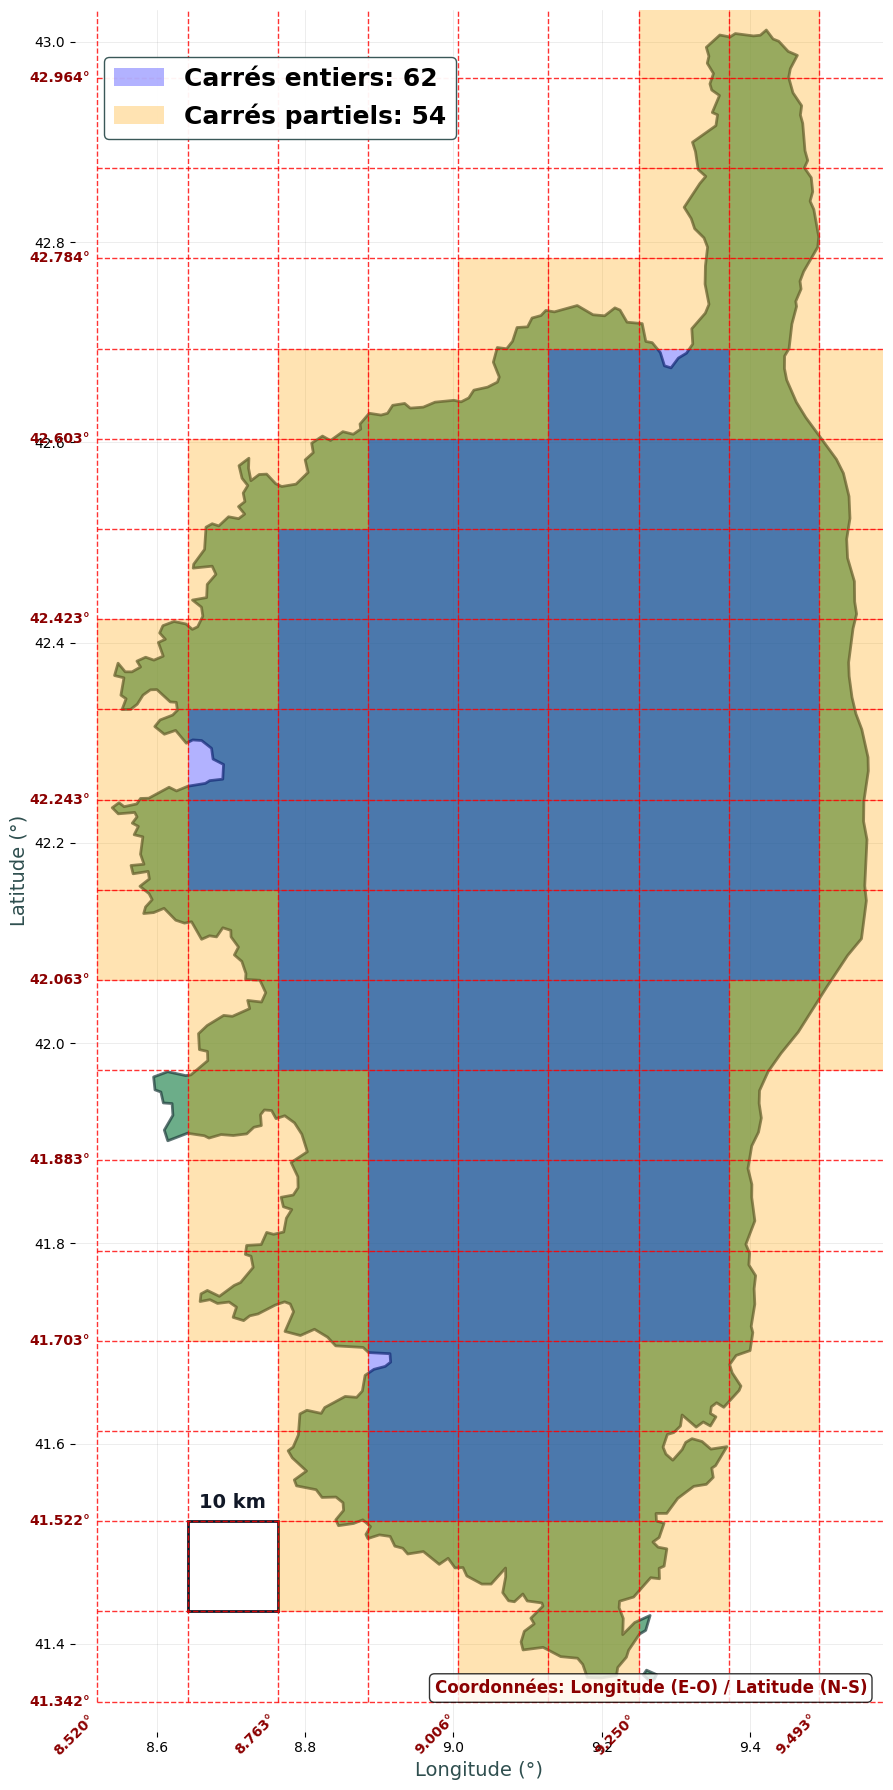


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%

🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_3200x3600.png
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_3200x3600.svg


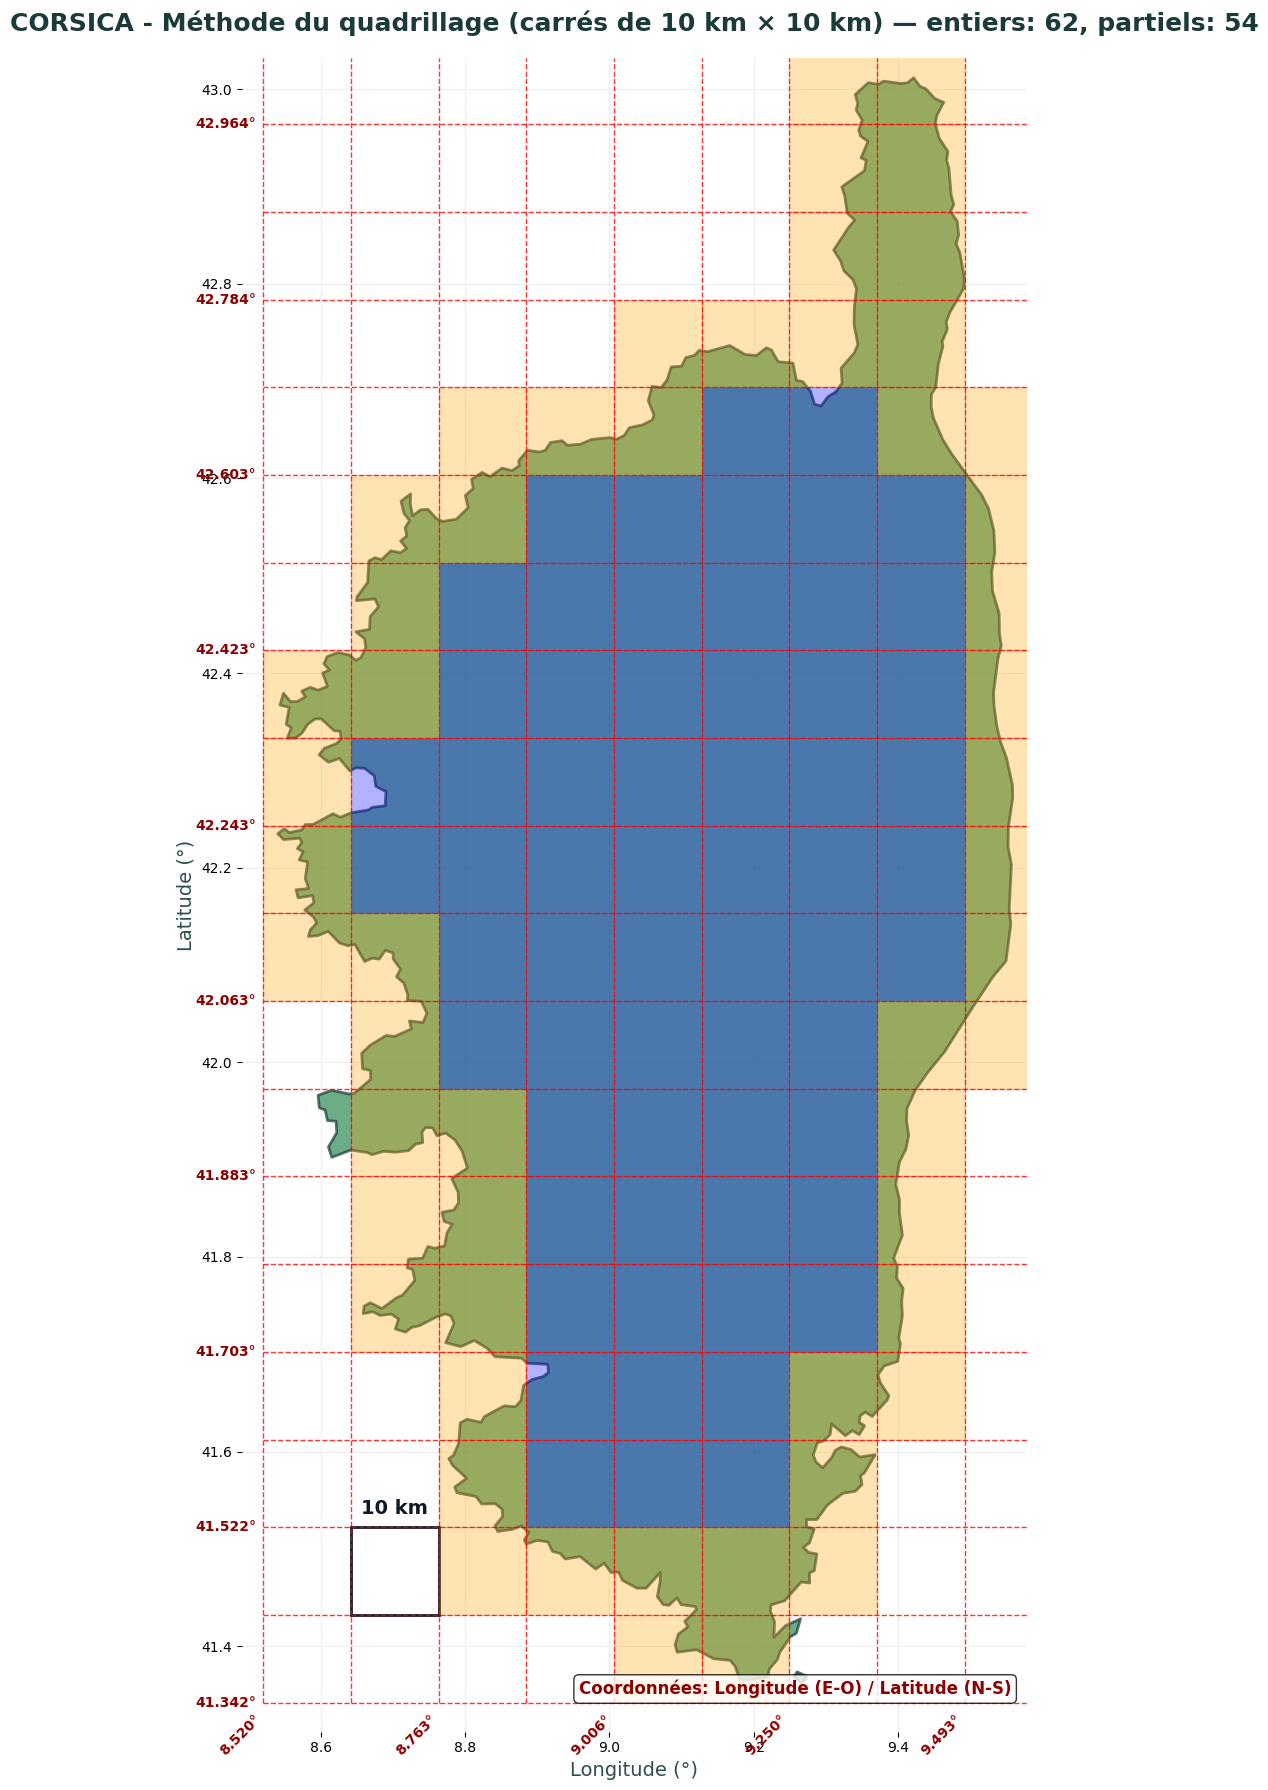


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%


In [10]:
# ===== MÉTHODE DU QUADRILLAGE POUR CALCULER LA SUPERFICIE =====
# Square grid method for area calculation - Perfect for Troisième level

def create_corsica_grid_exercise(corsica_data, grid_size_km=5, for_svg_title_counts=False):
    """
    Create a grid overlay on Corsica for area calculation exercises
    Students will count squares to estimate the area
    """
    
    # Get Corsica bounds
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # Convert grid size to degrees
    # 1 degree ≈ 111 km, but adjust for latitude
    lat_correction = np.cos(np.radians(center_lat))
    grid_size_deg_lat = grid_size_km / 111
    grid_size_deg_lon = grid_size_km / (111 * lat_correction)
    
    # Create grid
    padding = 0.02  # Small padding
    lon_range = np.arange(min_lon - padding, max_lon + padding + grid_size_deg_lon, grid_size_deg_lon)
    lat_range = np.arange(min_lat - padding, max_lat + padding + grid_size_deg_lat, grid_size_deg_lat)
    
    # Set up the plot with extra space for coordinate labels
    fig, ax = plt.subplots(1, 1, figsize=(16, 18))  # Increased size to accommodate labels
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Draw Corsica
    corsica_color = '#2E8B57'  # Sea green
    patches_list = []
    
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                coords_array = np.array(coords)
                polygon = patches.Polygon(coords_array, closed=True)
                patches_list.append(polygon)
    
    if patches_list:
        patch_collection = PatchCollection(patches_list, alpha=0.7)
        patch_collection.set_facecolors(corsica_color)
        patch_collection.set_edgecolors('#1C3A3A')
        patch_collection.set_linewidths(2)
        ax.add_collection(patch_collection)
    
    # Draw the grid with coordinate labels
    grid_lines = []
    
    # Vertical lines (longitude) with labels
    for i, lon in enumerate(lon_range):
        line = plt.Line2D([lon, lon], [min_lat - padding, max_lat + padding], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
        
        # Add longitude label at the bottom of each vertical line
        # Only label every few lines to avoid overcrowding
        if i % 2 == 0 or len(lon_range) <= 8:  # Label every other line, or all if few lines
            ax.text(lon, min_lat - padding - 0.01, f'{lon:.3f}°', 
                   rotation=45, ha='right', va='top', fontsize=10, 
                   fontweight='bold', color='#8B0000')
    
    # Horizontal lines (latitude) with labels
    for i, lat in enumerate(lat_range):
        line = plt.Line2D([min_lon - padding, max_lon + padding], [lat, lat], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
        
        # Add latitude label at the left of each horizontal line
        # Only label every few lines to avoid overcrowding
        if i % 2 == 0 or len(lat_range) <= 8:  # Label every other line, or all if few lines
            ax.text(min_lon - padding - 0.01, lat, f'{lat:.3f}°', 
                   rotation=0, ha='right', va='center', fontsize=10, 
                   fontweight='bold', color='#8B0000')
    
    # Add a simple 10km scale square (second column, second row)
    try:
        lon1, lon2 = lon_range[1], lon_range[2]
        lat1, lat2 = lat_range[1], lat_range[2]
        scale_square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1,
                                         facecolor='none', edgecolor='#111827', linewidth=2)
        ax.add_patch(scale_square)
        ax.text(lon1 + (lon2-lon1)/2, lat2 + (lat2-lat1)*0.1,
                f"{grid_size_km} km",
                ha='center', va='bottom', fontsize=14, fontweight='bold', color='#111827')
    except Exception:
        pass
    
    # Count squares that intersect with Corsica
    from matplotlib.path import Path
    
    # Create path from Corsica polygon for point-in-polygon tests
    corsica_paths = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                path = Path(coords)
                corsica_paths.append(path)
    
    # Count different types of squares
    total_squares = 0
    full_squares = 0
    partial_squares = 0
    empty_squares = 0
    
    square_info = []
    
    for i in range(len(lon_range) - 1):
        for j in range(len(lat_range) - 1):
            total_squares += 1
            
            # Define square corners
            lon1, lon2 = lon_range[i], lon_range[i + 1]
            lat1, lat2 = lat_range[j], lat_range[j + 1]
            
            # Test square corners and center
            corners = [
                (lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2),
                ((lon1 + lon2)/2, (lat1 + lat2)/2)  # center
            ]
            
            # Check how many points are inside Corsica
            inside_count = 0
            for point in corners:
                for path in corsica_paths:
                    if path.contains_point(point):
                        inside_count += 1
                        break
            
            # Classify square
            if inside_count == 5:  # All points inside
                square_type = 'full'
                full_squares += 1
                color = 'blue'
                alpha = 0.3
            elif inside_count > 0:  # Some points inside
                square_type = 'partial'
                partial_squares += 1
                color = 'orange'
                alpha = 0.3
            else:  # No points inside
                square_type = 'empty'
                empty_squares += 1
                continue  # Don't draw empty squares
            
            # Draw square with color coding
            square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1, 
                                     facecolor=color, alpha=alpha, edgecolor='red', linewidth=0.5)
            ax.add_patch(square)
            
            # Store info for exercise
            center_lon = (lon1 + lon2) / 2
            center_lat = (lat1 + lat2) / 2
            square_info.append({
                'id': f'{i}-{j}',
                'center': (center_lon, center_lat),
                'type': square_type,
                'corners': [(lon1, lat1), (lon2, lat2)]
            })
    
    # Set proper aspect ratio and limits with extra space for labels
    ax.set_aspect(1.0 / lat_correction)
    # Extend limits to accommodate coordinate labels
    extra_padding = 0.03
    ax.set_xlim(min_lon - padding - extra_padding, max_lon + padding)
    ax.set_ylim(min_lat - padding - extra_padding, max_lat + padding)
    
    # Styling
    if for_svg_title_counts:
        ax.set_title(f'CORSICA - Méthode du quadrillage (carrés de {grid_size_km} km × {grid_size_km} km) — entiers: {full_squares}, partiels: {partial_squares}',
                     fontsize=18, fontweight='bold', pad=20, color='#1C3A3A')
    else:
        ax.set_title("")
    ax.set_xlabel('Longitude (°)', fontsize=14, color='#2F4F4F')
    ax.set_ylabel('Latitude (°)', fontsize=14, color='#2F4F4F')
    
    # Optional legend: if not for_svg_title_counts, draw a BIG legend top-left
    if not for_svg_title_counts:
        legend_elements = [
            patches.Patch(facecolor='blue', alpha=0.3, label=f'Carrés entiers: {full_squares}'),
            patches.Patch(facecolor='orange', alpha=0.3, label=f'Carrés partiels: {partial_squares}'),
        ]
        leg = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98),
                         frameon=True, framealpha=0.95, facecolor='white', edgecolor='#2F4F4F',
                         fontsize=18)
        for text in leg.get_texts():
            text.set_fontweight('bold')
    
    # Grid and styling
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add coordinate labels explanation in bottom right
    coord_text = "Coordonnées: Longitude (E-O) / Latitude (N-S)"
    ax.text(0.98, 0.02, coord_text, transform=ax.transAxes, 
           ha='right', va='bottom', fontsize=12, 
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
           color='#8B0000', fontweight='bold')
    
    plt.tight_layout()
    # Save to processed with precise name
    width_px = int(fig.get_figwidth() * 200)
    height_px = int(fig.get_figheight() * 200)
    save_matplotlib_figure(fig, name_base="corsica_grid_matplotlib", grid_km=grid_size_km, width_px=width_px, height_px=height_px)
    plt.show()
    
    # Calculate area estimation
    area_per_square = grid_size_km * grid_size_km
    estimated_area_min = full_squares * area_per_square
    estimated_area_max = (full_squares + partial_squares) * area_per_square
    estimated_area_avg = (estimated_area_min + estimated_area_max) / 2
    
    print(f"\n📊 RÉSULTATS DU QUADRILLAGE:")
    print(f"   🔲 Taille d'un carré: {grid_size_km} km × {grid_size_km} km = {area_per_square} km²")
    print(f"   📈 Total des carrés analysés: {total_squares}")
    print(f"   🟦 Carrés entièrement dans la Corse: {full_squares}")
    print(f"   🟧 Carrés partiellement dans la Corse: {partial_squares}")
    print(f"   ⬜ Carrés vides: {empty_squares}")
    print(f"\n📏 ESTIMATION DE LA SUPERFICIE:")
    print(f"   • Estimation minimale: {estimated_area_min:,} km² (carrés entiers seulement)")
    print(f"   • Estimation maximale: {estimated_area_max:,} km² (entiers + partiels)")
    print(f"   • Estimation moyenne: {estimated_area_avg:,.0f} km²")
    print(f"   • Superficie officielle: 8,722 km²")
    print(f"   • Erreur relative: {abs(estimated_area_avg - 8722)/8722*100:.1f}%")
    
    return {
        'grid_size_km': grid_size_km,
        'full_squares': full_squares,
        'partial_squares': partial_squares,
        'estimated_area': estimated_area_avg,
        'square_info': square_info
    }

# Create the grid exercise for PNG (legend top-left, no title)
print("🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)")
print("=" * 60)
grid_results = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=False)

# Create the version for SVG (no legend, counts in title)
print("\n🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)")
print("=" * 65)
_ = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=True)

🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)

📍 COORDONNÉES DE TOUTES LES LIGNES DU QUADRILLAGE:
   🔸 x_labels (Toutes longitudes affichées): [np.float64(8.52), np.float64(8.642), np.float64(8.763), np.float64(8.885), np.float64(9.006), np.float64(9.128), np.float64(9.25), np.float64(9.371), np.float64(9.493), np.float64(9.614)]
   🔸 y_labels (Toutes latitudes affichées): [np.float64(41.342), np.float64(41.432), np.float64(41.522), np.float64(41.612), np.float64(41.703), np.float64(41.793), np.float64(41.883), np.float64(41.973), np.float64(42.063), np.float64(42.153), np.float64(42.243), np.float64(42.333), np.float64(42.423), np.float64(42.513), np.float64(42.603), np.float64(42.694), np.float64(42.784), np.float64(42.874), np.float64(42.964), np.float64(43.054)]
   📏 Nombre total de lignes verticales étiquetées: 10
   📏 Nombre total de lignes horizontales étiquetées: 20
saved: data/processed/corsica/corsica_grid_matplotlib_grid10km_3200x3600.png
saved: data/processe

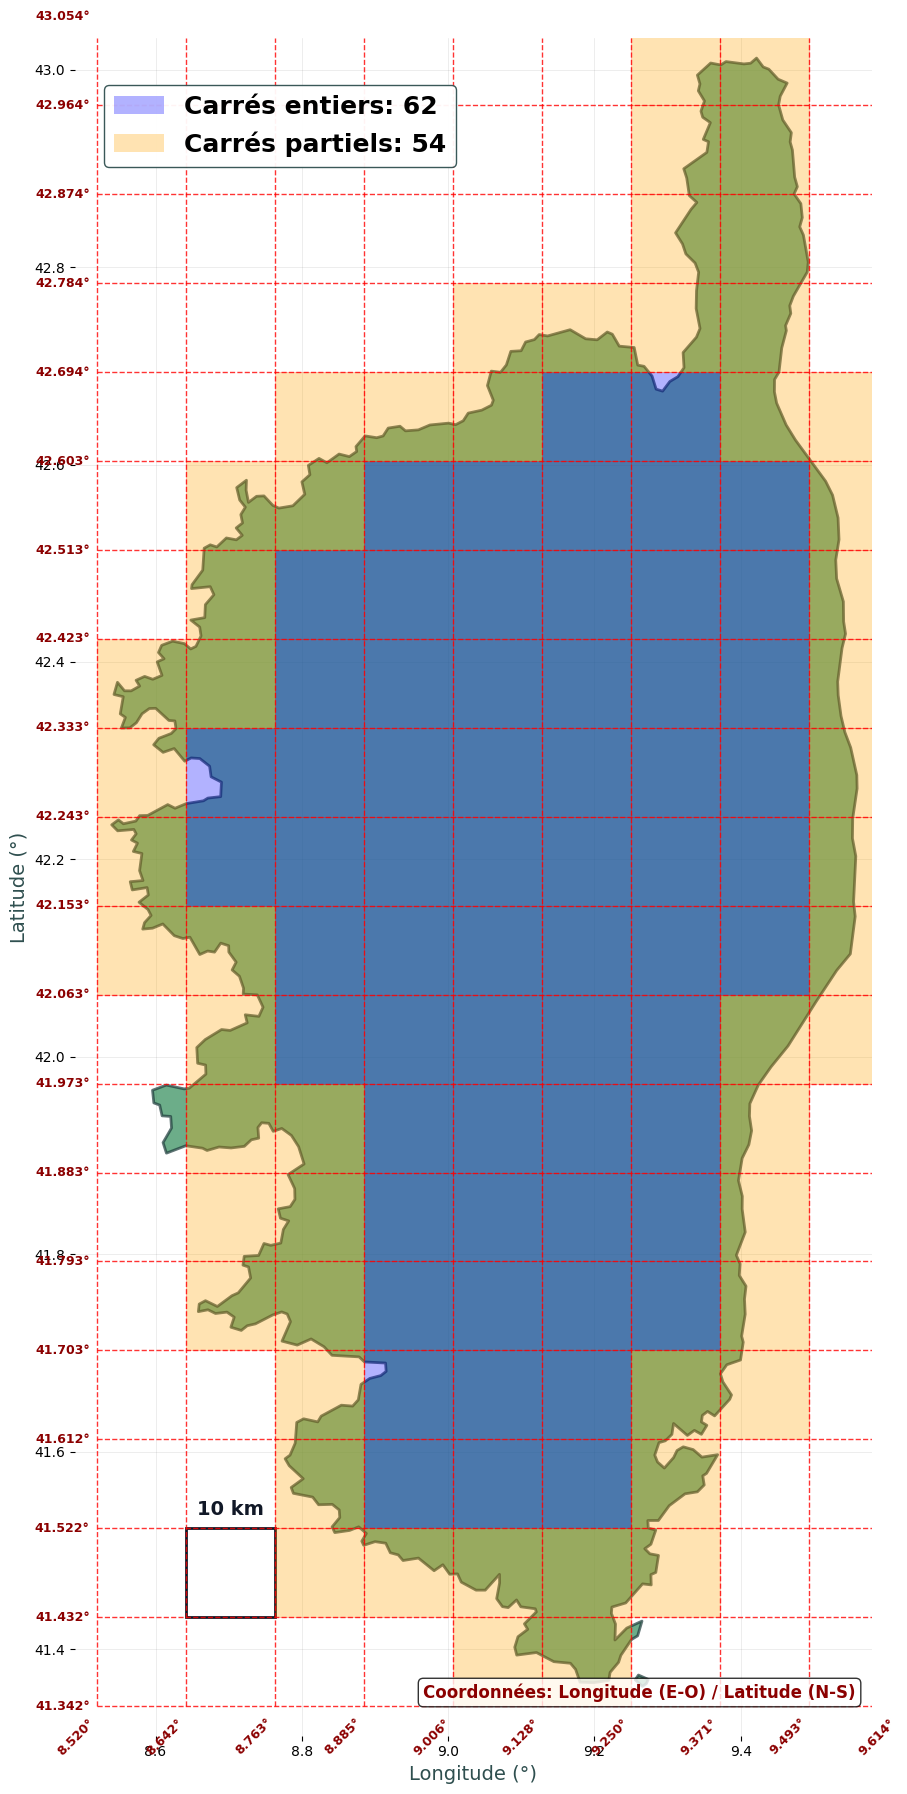


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%

🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)

📍 COORDONNÉES DE TOUTES LES LIGNES DU QUADRILLAGE:
   🔸 x_labels (Toutes longitudes affichées): [np.float64(8.52), np.float64(8.642), np.float64(8.763), np.float64(8.885), np.float64(9.006), np.float64(9.128), np.float64(9.25), np.float64(9.371), np.float64(9.493), np.float64(9.614)]
   🔸 y_labels (Toutes latitudes affichées): [np.float64(41.342), np.float64(41.432), np.float64(41.522), np.float64(41.612), np.float64(41.703), np.float64(41.793), np.flo

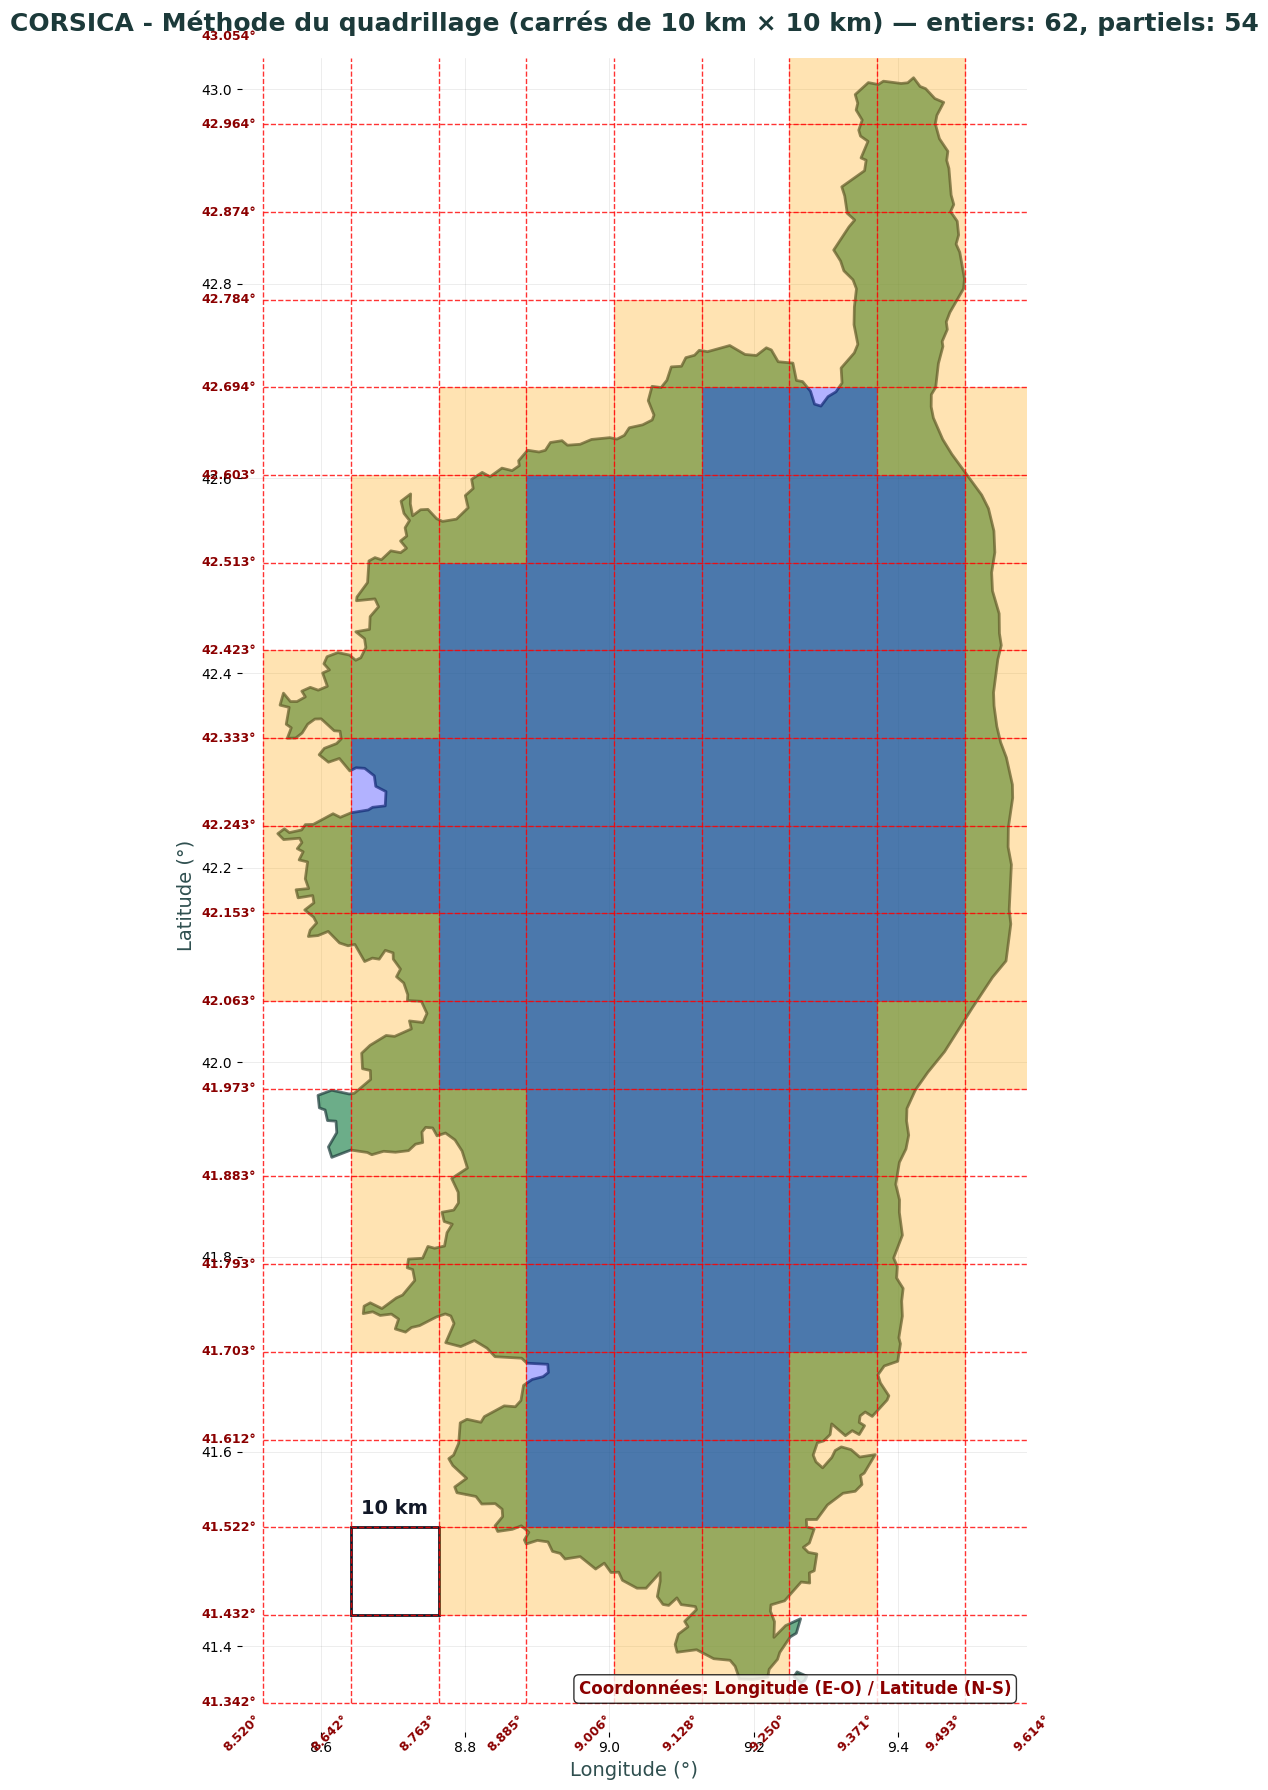


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%


In [12]:
# ===== MÉTHODE DU QUADRILLAGE POUR CALCULER LA SUPERFICIE =====
# Square grid method for area calculation - Perfect for Troisième level

def create_corsica_grid_exercise(corsica_data, grid_size_km=5, for_svg_title_counts=False):
    """
    Create a grid overlay on Corsica for area calculation exercises
    Students will count squares to estimate the area
    """
    
    # Get Corsica bounds
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # Convert grid size to degrees
    # 1 degree ≈ 111 km, but adjust for latitude
    lat_correction = np.cos(np.radians(center_lat))
    grid_size_deg_lat = grid_size_km / 111
    grid_size_deg_lon = grid_size_km / (111 * lat_correction)
    
    # Create grid
    padding = 0.02  # Small padding
    lon_range = np.arange(min_lon - padding, max_lon + padding + grid_size_deg_lon, grid_size_deg_lon)
    lat_range = np.arange(min_lat - padding, max_lat + padding + grid_size_deg_lat, grid_size_deg_lat)
    
    # Set up the plot with extra space for coordinate labels
    fig, ax = plt.subplots(1, 1, figsize=(16, 18))  # Increased size to accommodate labels
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Draw Corsica
    corsica_color = '#2E8B57'  # Sea green
    patches_list = []
    
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                coords_array = np.array(coords)
                polygon = patches.Polygon(coords_array, closed=True)
                patches_list.append(polygon)
    
    if patches_list:
        patch_collection = PatchCollection(patches_list, alpha=0.7)
        patch_collection.set_facecolors(corsica_color)
        patch_collection.set_edgecolors('#1C3A3A')
        patch_collection.set_linewidths(2)
        ax.add_collection(patch_collection)
    
    # Draw the grid with coordinate labels
    grid_lines = []
    
    # Store coordinate values for printing
    x_labels = []  # Longitude values
    y_labels = []  # Latitude values
    
    # Vertical lines (longitude) with labels
    for i, lon in enumerate(lon_range):
        line = plt.Line2D([lon, lon], [min_lat - padding, max_lat + padding], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
        
        # Add longitude label at the bottom of EVERY vertical line
        x_labels.append(round(lon, 3))  # Store the exact value displayed
        ax.text(lon, min_lat - padding - 0.01, f'{lon:.3f}°', 
               rotation=45, ha='right', va='top', fontsize=9, 
               fontweight='bold', color='#8B0000')
    
    # Horizontal lines (latitude) with labels
    for i, lat in enumerate(lat_range):
        line = plt.Line2D([min_lon - padding, max_lon + padding], [lat, lat], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
        
        # Add latitude label at the left of EVERY horizontal line
        y_labels.append(round(lat, 3))  # Store the exact value displayed
        ax.text(min_lon - padding - 0.01, lat, f'{lat:.3f}°', 
               rotation=0, ha='right', va='center', fontsize=9, 
               fontweight='bold', color='#8B0000')
    
    # Print the coordinate lists
    print(f"\n📍 COORDONNÉES DE TOUTES LES LIGNES DU QUADRILLAGE:")
    print(f"   🔸 x_labels (Toutes longitudes affichées): {x_labels}")
    print(f"   🔸 y_labels (Toutes latitudes affichées): {y_labels}")
    print(f"   📏 Nombre total de lignes verticales étiquetées: {len(x_labels)}")
    print(f"   📏 Nombre total de lignes horizontales étiquetées: {len(y_labels)}")
    
    # Add a simple 10km scale square (second column, second row)
    try:
        lon1, lon2 = lon_range[1], lon_range[2]
        lat1, lat2 = lat_range[1], lat_range[2]
        scale_square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1,
                                         facecolor='none', edgecolor='#111827', linewidth=2)
        ax.add_patch(scale_square)
        ax.text(lon1 + (lon2-lon1)/2, lat2 + (lat2-lat1)*0.1,
                f"{grid_size_km} km",
                ha='center', va='bottom', fontsize=14, fontweight='bold', color='#111827')
    except Exception:
        pass
    
    # Count squares that intersect with Corsica
    from matplotlib.path import Path
    
    # Create path from Corsica polygon for point-in-polygon tests
    corsica_paths = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                path = Path(coords)
                corsica_paths.append(path)
    
    # Count different types of squares
    total_squares = 0
    full_squares = 0
    partial_squares = 0
    empty_squares = 0
    
    square_info = []
    
    for i in range(len(lon_range) - 1):
        for j in range(len(lat_range) - 1):
            total_squares += 1
            
            # Define square corners
            lon1, lon2 = lon_range[i], lon_range[i + 1]
            lat1, lat2 = lat_range[j], lat_range[j + 1]
            
            # Test square corners and center
            corners = [
                (lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2),
                ((lon1 + lon2)/2, (lat1 + lat2)/2)  # center
            ]
            
            # Check how many points are inside Corsica
            inside_count = 0
            for point in corners:
                for path in corsica_paths:
                    if path.contains_point(point):
                        inside_count += 1
                        break
            
            # Classify square
            if inside_count == 5:  # All points inside
                square_type = 'full'
                full_squares += 1
                color = 'blue'
                alpha = 0.3
            elif inside_count > 0:  # Some points inside
                square_type = 'partial'
                partial_squares += 1
                color = 'orange'
                alpha = 0.3
            else:  # No points inside
                square_type = 'empty'
                empty_squares += 1
                continue  # Don't draw empty squares
            
            # Draw square with color coding
            square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1, 
                                     facecolor=color, alpha=alpha, edgecolor='red', linewidth=0.5)
            ax.add_patch(square)
            
            # Store info for exercise
            center_lon = (lon1 + lon2) / 2
            center_lat = (lat1 + lat2) / 2
            square_info.append({
                'id': f'{i}-{j}',
                'center': (center_lon, center_lat),
                'type': square_type,
                'corners': [(lon1, lat1), (lon2, lat2)]
            })
    
    # Set proper aspect ratio and limits with extra space for labels
    ax.set_aspect(1.0 / lat_correction)
    # Extend limits to accommodate coordinate labels
    extra_padding = 0.03
    ax.set_xlim(min_lon - padding - extra_padding, max_lon + padding)
    ax.set_ylim(min_lat - padding - extra_padding, max_lat + padding)
    
    # Styling
    if for_svg_title_counts:
        ax.set_title(f'CORSICA - Méthode du quadrillage (carrés de {grid_size_km} km × {grid_size_km} km) — entiers: {full_squares}, partiels: {partial_squares}',
                     fontsize=18, fontweight='bold', pad=20, color='#1C3A3A')
    else:
        ax.set_title("")
    ax.set_xlabel('Longitude (°)', fontsize=14, color='#2F4F4F')
    ax.set_ylabel('Latitude (°)', fontsize=14, color='#2F4F4F')
    
    # Optional legend: if not for_svg_title_counts, draw a BIG legend top-left
    if not for_svg_title_counts:
        legend_elements = [
            patches.Patch(facecolor='blue', alpha=0.3, label=f'Carrés entiers: {full_squares}'),
            patches.Patch(facecolor='orange', alpha=0.3, label=f'Carrés partiels: {partial_squares}'),
        ]
        leg = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98),
                         frameon=True, framealpha=0.95, facecolor='white', edgecolor='#2F4F4F',
                         fontsize=18)
        for text in leg.get_texts():
            text.set_fontweight('bold')
    
    # Grid and styling
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add coordinate labels explanation in bottom right
    coord_text = "Coordonnées: Longitude (E-O) / Latitude (N-S)"
    ax.text(0.98, 0.02, coord_text, transform=ax.transAxes, 
           ha='right', va='bottom', fontsize=12, 
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
           color='#8B0000', fontweight='bold')
    
    plt.tight_layout()
    # Save to processed with precise name
    width_px = int(fig.get_figwidth() * 200)
    height_px = int(fig.get_figheight() * 200)
    save_matplotlib_figure(fig, name_base="corsica_grid_matplotlib", grid_km=grid_size_km, width_px=width_px, height_px=height_px)
    plt.show()
    
    # Calculate area estimation
    area_per_square = grid_size_km * grid_size_km
    estimated_area_min = full_squares * area_per_square
    estimated_area_max = (full_squares + partial_squares) * area_per_square
    estimated_area_avg = (estimated_area_min + estimated_area_max) / 2
    
    print(f"\n📊 RÉSULTATS DU QUADRILLAGE:")
    print(f"   🔲 Taille d'un carré: {grid_size_km} km × {grid_size_km} km = {area_per_square} km²")
    print(f"   📈 Total des carrés analysés: {total_squares}")
    print(f"   🟦 Carrés entièrement dans la Corse: {full_squares}")
    print(f"   🟧 Carrés partiellement dans la Corse: {partial_squares}")
    print(f"   ⬜ Carrés vides: {empty_squares}")
    print(f"\n📏 ESTIMATION DE LA SUPERFICIE:")
    print(f"   • Estimation minimale: {estimated_area_min:,} km² (carrés entiers seulement)")
    print(f"   • Estimation maximale: {estimated_area_max:,} km² (entiers + partiels)")
    print(f"   • Estimation moyenne: {estimated_area_avg:,.0f} km²")
    print(f"   • Superficie officielle: 8,722 km²")
    print(f"   • Erreur relative: {abs(estimated_area_avg - 8722)/8722*100:.1f}%")
    
    return {
        'grid_size_km': grid_size_km,
        'full_squares': full_squares,
        'partial_squares': partial_squares,
        'estimated_area': estimated_area_avg,
        'square_info': square_info
    }

# Create the grid exercise for PNG (legend top-left, no title)
print("🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)")
print("=" * 60)
grid_results = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=False)

# Create the version for SVG (no legend, counts in title)
print("\n🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)")
print("=" * 65)
_ = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=True)

🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)

📍 COORDONNÉES DES LIGNES DU QUADRILLAGE:
   🔸 x_labels (Longitudes affichées): [np.float64(8.52), np.float64(8.763), np.float64(9.006), np.float64(9.25), np.float64(9.493)]
   🔸 y_labels (Latitudes affichées): [np.float64(41.342), np.float64(41.522), np.float64(41.703), np.float64(41.883), np.float64(42.063), np.float64(42.243), np.float64(42.423), np.float64(42.603), np.float64(42.784), np.float64(42.964)]
   📏 Nombre de lignes verticales étiquetées: 5
   📏 Nombre de lignes horizontales étiquetées: 10

📍 TOUTES LES COORDONNÉES DES LIGNES POINTILLÉES:
   🔹 Toutes longitudes (lignes verticales): [np.float64(8.52), np.float64(8.642), np.float64(8.763), np.float64(8.885), np.float64(9.006), np.float64(9.128), np.float64(9.25), np.float64(9.371), np.float64(9.493), np.float64(9.614)]
   🔹 Toutes latitudes (lignes horizontales): [np.float64(41.342), np.float64(41.432), np.float64(41.522), np.float64(41.612), np.float64(41.703), 

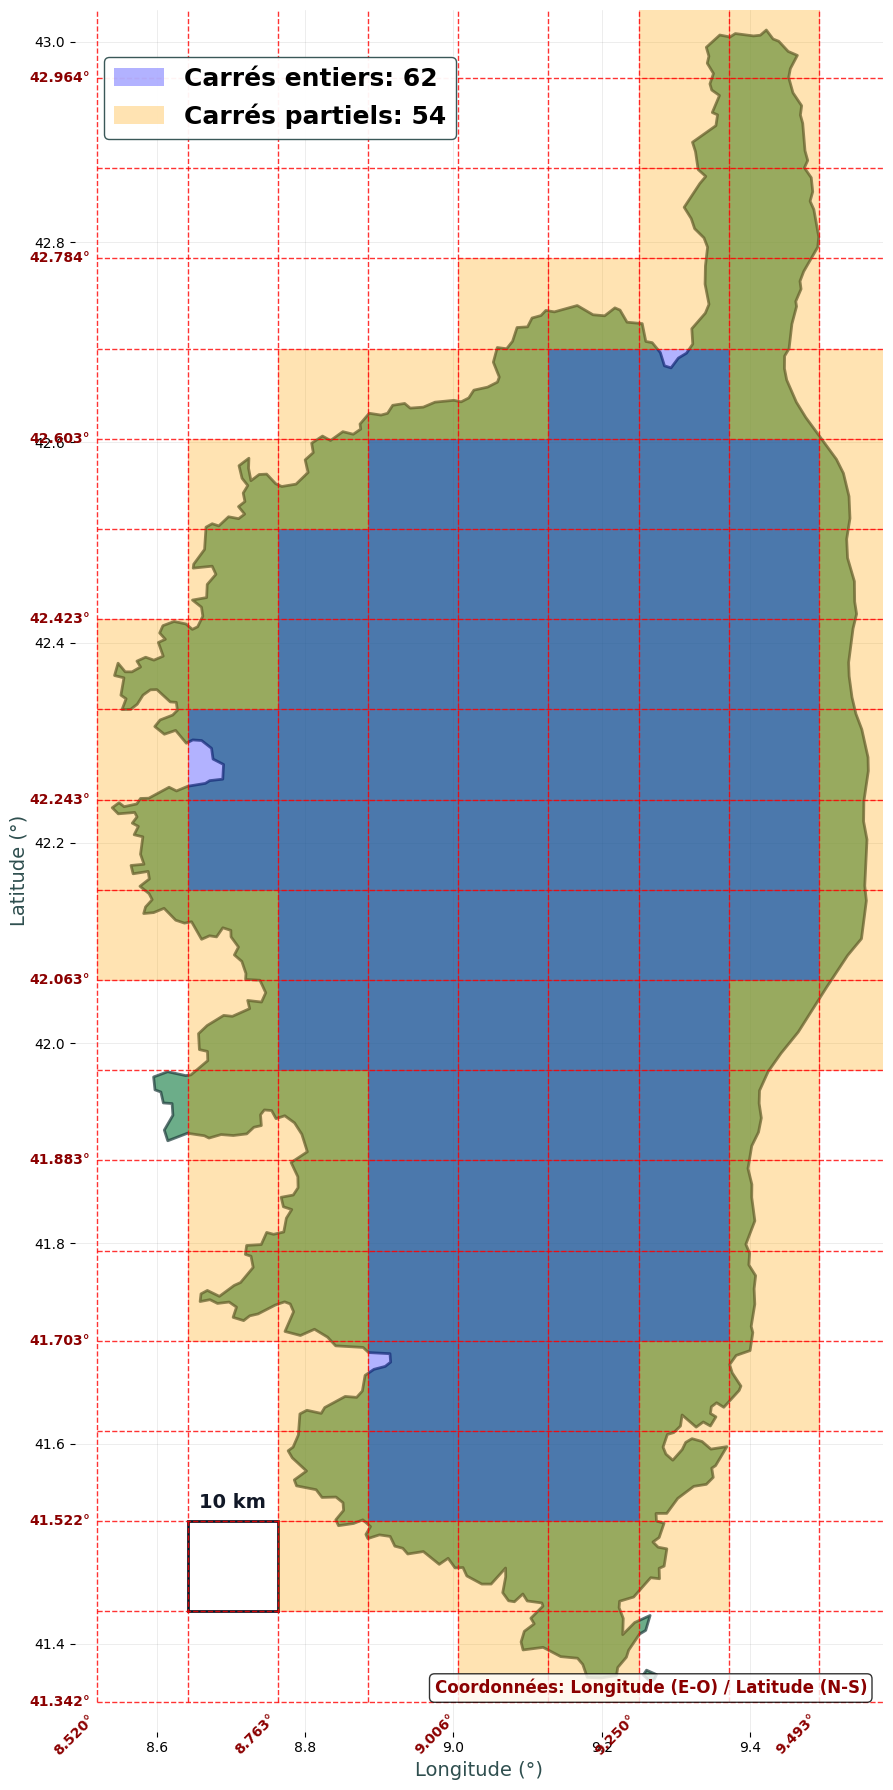


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%

🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)

📍 COORDONNÉES DES LIGNES DU QUADRILLAGE:
   🔸 x_labels (Longitudes affichées): [np.float64(8.52), np.float64(8.763), np.float64(9.006), np.float64(9.25), np.float64(9.493)]
   🔸 y_labels (Latitudes affichées): [np.float64(41.342), np.float64(41.522), np.float64(41.703), np.float64(41.883), np.float64(42.063), np.float64(42.243), np.float64(42.423), np.float64(42.603), np.float64(42.784), np.float64(42.964)]
   📏 Nombre de lignes verticales étiquetées: 

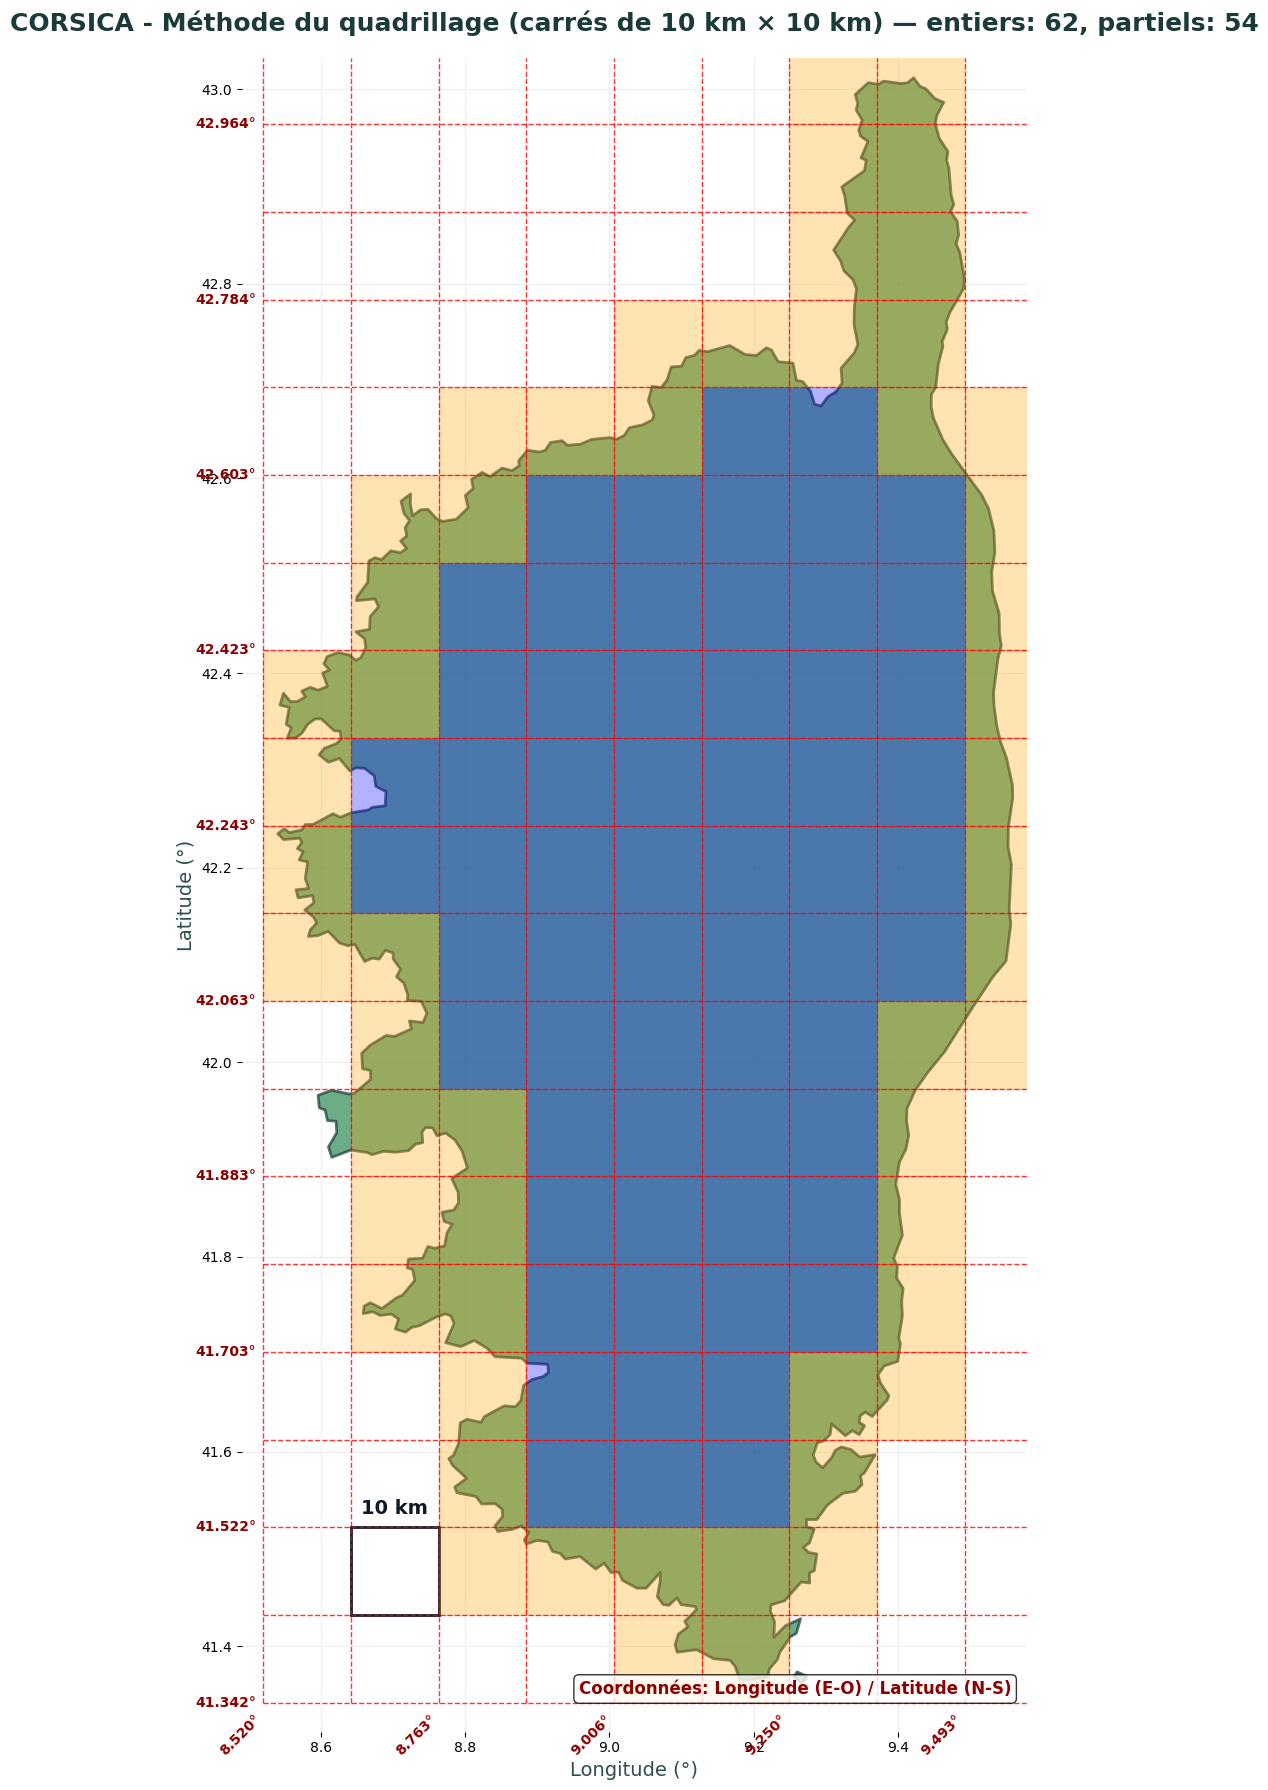


📊 RÉSULTATS DU QUADRILLAGE:
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%


In [11]:
# ===== MÉTHODE DU QUADRILLAGE POUR CALCULER LA SUPERFICIE =====
# Square grid method for area calculation - Perfect for Troisième level

def create_corsica_grid_exercise(corsica_data, grid_size_km=5, for_svg_title_counts=False):
    """
    Create a grid overlay on Corsica for area calculation exercises
    Students will count squares to estimate the area
    """
    
    # Get Corsica bounds
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # Convert grid size to degrees
    # 1 degree ≈ 111 km, but adjust for latitude
    lat_correction = np.cos(np.radians(center_lat))
    grid_size_deg_lat = grid_size_km / 111
    grid_size_deg_lon = grid_size_km / (111 * lat_correction)
    
    # Create grid
    padding = 0.02  # Small padding
    lon_range = np.arange(min_lon - padding, max_lon + padding + grid_size_deg_lon, grid_size_deg_lon)
    lat_range = np.arange(min_lat - padding, max_lat + padding + grid_size_deg_lat, grid_size_deg_lat)
    
    # Set up the plot with extra space for coordinate labels
    fig, ax = plt.subplots(1, 1, figsize=(16, 18))  # Increased size to accommodate labels
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Draw Corsica
    corsica_color = '#2E8B57'  # Sea green
    patches_list = []
    
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                coords_array = np.array(coords)
                polygon = patches.Polygon(coords_array, closed=True)
                patches_list.append(polygon)
    
    if patches_list:
        patch_collection = PatchCollection(patches_list, alpha=0.7)
        patch_collection.set_facecolors(corsica_color)
        patch_collection.set_edgecolors('#1C3A3A')
        patch_collection.set_linewidths(2)
        ax.add_collection(patch_collection)
    
    # Draw the grid with coordinate labels
    grid_lines = []
    
    # Store coordinate values for printing
    x_labels = []  # Longitude values
    y_labels = []  # Latitude values
    
    # Vertical lines (longitude) with labels
    for i, lon in enumerate(lon_range):
        line = plt.Line2D([lon, lon], [min_lat - padding, max_lat + padding], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
        
        # Add longitude label at the bottom of each vertical line
        # Only label every few lines to avoid overcrowding
        if i % 2 == 0 or len(lon_range) <= 8:  # Label every other line, or all if few lines
            x_labels.append(round(lon, 3))  # Store the exact value displayed
            ax.text(lon, min_lat - padding - 0.01, f'{lon:.3f}°', 
                   rotation=45, ha='right', va='top', fontsize=10, 
                   fontweight='bold', color='#8B0000')
    
    # Horizontal lines (latitude) with labels
    for i, lat in enumerate(lat_range):
        line = plt.Line2D([min_lon - padding, max_lon + padding], [lat, lat], 
                         color='red', linewidth=1, alpha=0.8, linestyle='--')
        ax.add_line(line)
        
        # Add latitude label at the left of each horizontal line
        # Only label every few lines to avoid overcrowding
        if i % 2 == 0 or len(lat_range) <= 8:  # Label every other line, or all if few lines
            y_labels.append(round(lat, 3))  # Store the exact value displayed
            ax.text(min_lon - padding - 0.01, lat, f'{lat:.3f}°', 
                   rotation=0, ha='right', va='center', fontsize=10, 
                   fontweight='bold', color='#8B0000')
    
    # Print the coordinate lists
    print(f"\n📍 COORDONNÉES DES LIGNES DU QUADRILLAGE:")
    print(f"   🔸 x_labels (Longitudes affichées): {x_labels}")
    print(f"   🔸 y_labels (Latitudes affichées): {y_labels}")
    print(f"   📏 Nombre de lignes verticales étiquetées: {len(x_labels)}")
    print(f"   📏 Nombre de lignes horizontales étiquetées: {len(y_labels)}")
    
    # Also print ALL dash lines coordinates (including non-labeled ones)
    all_x_coords = [round(lon, 3) for lon in lon_range]
    all_y_coords = [round(lat, 3) for lat in lat_range]
    print(f"\n📍 TOUTES LES COORDONNÉES DES LIGNES POINTILLÉES:")
    print(f"   🔹 Toutes longitudes (lignes verticales): {all_x_coords}")
    print(f"   🔹 Toutes latitudes (lignes horizontales): {all_y_coords}")
    print(f"   📏 Total lignes verticales: {len(all_x_coords)}")
    print(f"   📏 Total lignes horizontales: {len(all_y_coords)}")
    
    # Add a simple 10km scale square (second column, second row)
    try:
        lon1, lon2 = lon_range[1], lon_range[2]
        lat1, lat2 = lat_range[1], lat_range[2]
        scale_square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1,
                                         facecolor='none', edgecolor='#111827', linewidth=2)
        ax.add_patch(scale_square)
        ax.text(lon1 + (lon2-lon1)/2, lat2 + (lat2-lat1)*0.1,
                f"{grid_size_km} km",
                ha='center', va='bottom', fontsize=14, fontweight='bold', color='#111827')
    except Exception:
        pass
    
    # Count squares that intersect with Corsica
    from matplotlib.path import Path
    
    # Create path from Corsica polygon for point-in-polygon tests
    corsica_paths = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                path = Path(coords)
                corsica_paths.append(path)
    
    # Count different types of squares
    total_squares = 0
    full_squares = 0
    partial_squares = 0
    empty_squares = 0
    
    square_info = []
    
    for i in range(len(lon_range) - 1):
        for j in range(len(lat_range) - 1):
            total_squares += 1
            
            # Define square corners
            lon1, lon2 = lon_range[i], lon_range[i + 1]
            lat1, lat2 = lat_range[j], lat_range[j + 1]
            
            # Test square corners and center
            corners = [
                (lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2),
                ((lon1 + lon2)/2, (lat1 + lat2)/2)  # center
            ]
            
            # Check how many points are inside Corsica
            inside_count = 0
            for point in corners:
                for path in corsica_paths:
                    if path.contains_point(point):
                        inside_count += 1
                        break
            
            # Classify square
            if inside_count == 5:  # All points inside
                square_type = 'full'
                full_squares += 1
                color = 'blue'
                alpha = 0.3
            elif inside_count > 0:  # Some points inside
                square_type = 'partial'
                partial_squares += 1
                color = 'orange'
                alpha = 0.3
            else:  # No points inside
                square_type = 'empty'
                empty_squares += 1
                continue  # Don't draw empty squares
            
            # Draw square with color coding
            square = patches.Rectangle((lon1, lat1), lon2-lon1, lat2-lat1, 
                                     facecolor=color, alpha=alpha, edgecolor='red', linewidth=0.5)
            ax.add_patch(square)
            
            # Store info for exercise
            center_lon = (lon1 + lon2) / 2
            center_lat = (lat1 + lat2) / 2
            square_info.append({
                'id': f'{i}-{j}',
                'center': (center_lon, center_lat),
                'type': square_type,
                'corners': [(lon1, lat1), (lon2, lat2)]
            })
    
    # Set proper aspect ratio and limits with extra space for labels
    ax.set_aspect(1.0 / lat_correction)
    # Extend limits to accommodate coordinate labels
    extra_padding = 0.03
    ax.set_xlim(min_lon - padding - extra_padding, max_lon + padding)
    ax.set_ylim(min_lat - padding - extra_padding, max_lat + padding)
    
    # Styling
    if for_svg_title_counts:
        ax.set_title(f'CORSICA - Méthode du quadrillage (carrés de {grid_size_km} km × {grid_size_km} km) — entiers: {full_squares}, partiels: {partial_squares}',
                     fontsize=18, fontweight='bold', pad=20, color='#1C3A3A')
    else:
        ax.set_title("")
    ax.set_xlabel('Longitude (°)', fontsize=14, color='#2F4F4F')
    ax.set_ylabel('Latitude (°)', fontsize=14, color='#2F4F4F')
    
    # Optional legend: if not for_svg_title_counts, draw a BIG legend top-left
    if not for_svg_title_counts:
        legend_elements = [
            patches.Patch(facecolor='blue', alpha=0.3, label=f'Carrés entiers: {full_squares}'),
            patches.Patch(facecolor='orange', alpha=0.3, label=f'Carrés partiels: {partial_squares}'),
        ]
        leg = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98),
                         frameon=True, framealpha=0.95, facecolor='white', edgecolor='#2F4F4F',
                         fontsize=18)
        for text in leg.get_texts():
            text.set_fontweight('bold')
    
    # Grid and styling
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add coordinate labels explanation in bottom right
    coord_text = "Coordonnées: Longitude (E-O) / Latitude (N-S)"
    ax.text(0.98, 0.02, coord_text, transform=ax.transAxes, 
           ha='right', va='bottom', fontsize=12, 
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
           color='#8B0000', fontweight='bold')
    
    plt.tight_layout()
    # Save to processed with precise name
    width_px = int(fig.get_figwidth() * 200)
    height_px = int(fig.get_figheight() * 200)
    save_matplotlib_figure(fig, name_base="corsica_grid_matplotlib", grid_km=grid_size_km, width_px=width_px, height_px=height_px)
    plt.show()
    
    # Calculate area estimation
    area_per_square = grid_size_km * grid_size_km
    estimated_area_min = full_squares * area_per_square
    estimated_area_max = (full_squares + partial_squares) * area_per_square
    estimated_area_avg = (estimated_area_min + estimated_area_max) / 2
    
    print(f"\n📊 RÉSULTATS DU QUADRILLAGE:")
    print(f"   🔲 Taille d'un carré: {grid_size_km} km × {grid_size_km} km = {area_per_square} km²")
    print(f"   📈 Total des carrés analysés: {total_squares}")
    print(f"   🟦 Carrés entièrement dans la Corse: {full_squares}")
    print(f"   🟧 Carrés partiellement dans la Corse: {partial_squares}")
    print(f"   ⬜ Carrés vides: {empty_squares}")
    print(f"\n📏 ESTIMATION DE LA SUPERFICIE:")
    print(f"   • Estimation minimale: {estimated_area_min:,} km² (carrés entiers seulement)")
    print(f"   • Estimation maximale: {estimated_area_max:,} km² (entiers + partiels)")
    print(f"   • Estimation moyenne: {estimated_area_avg:,.0f} km²")
    print(f"   • Superficie officielle: 8,722 km²")
    print(f"   • Erreur relative: {abs(estimated_area_avg - 8722)/8722*100:.1f}%")
    
    return {
        'grid_size_km': grid_size_km,
        'full_squares': full_squares,
        'partial_squares': partial_squares,
        'estimated_area': estimated_area_avg,
        'square_info': square_info
    }

# Create the grid exercise for PNG (legend top-left, no title)
print("🎯 EXERCICE: Calcul de superficie par quadrillage (PNG Legend)")
print("=" * 60)
grid_results = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=False)

# Create the version for SVG (no legend, counts in title)
print("\n🎯 EXERCICE: Calcul de superficie par quadrillage (SVG Title Counts)")
print("=" * 65)
_ = create_corsica_grid_exercise(corsica_data, grid_size_km=10, for_svg_title_counts=True)

In [21]:
# ===== EXERCICES PRÉPARÉS POUR LES ÉLÈVES =====
# Ready-to-use exercises for students

def generate_student_exercises(corsica_data, grid_results):
    """Generate specific exercises for students to work on"""
    
    print("\n" + "="*70)
    print("📝 FICHE D'EXERCICES - GÉOMÉTRIE ET CARTOGRAPHIE")
    print("🗺️  Sujet: La Corse - Calculs géométriques")
    print("🎓 Niveau: Troisième")
    print("="*70)
    
    # Exercise 1: Basic measurements
    print("\n📐 EXERCICE 1: Mesures et échelles")
    print("-" * 40)
    print("Données fournies:")
    
    # Get Corsica bounds for the exercise
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # Calculate real dimensions
    def haversine_distance(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return c * 6371
    
    width_km = haversine_distance(min_lon, center_lat, max_lon, center_lat)
    height_km = haversine_distance((min_lon + max_lon)/2, min_lat, (min_lon + max_lon)/2, max_lat)
    
    print(f"• Coordonnées extrêmes de la Corse:")
    print(f"  - Nord: {max_lat:.3f}° N")
    print(f"  - Sud: {min_lat:.3f}° N") 
    print(f"  - Est: {max_lon:.3f}° E")
    print(f"  - Ouest: {min_lon:.3f}° E")
    print(f"• Conversion: 1° ≈ 111 km (à l'équateur)")
    print(f"• Correction latitude: cos({center_lat:.1f}°) = {np.cos(np.radians(center_lat)):.3f}")
    
    print(f"\nQuestions:")
    print(f"1.1) Calculez la largeur maximale de la Corse en degrés.")
    print(f"     Réponse attendue: {max_lon - min_lon:.3f}°")
    print(f"\n1.2) Calculez la hauteur maximale de la Corse en degrés.")
    print(f"     Réponse attendue: {max_lat - min_lat:.3f}°")
    print(f"\n1.3) Convertissez ces mesures en kilomètres (utilisez la correction de latitude).")
    print(f"     Largeur: ______ km (≈ {width_km:.0f} km)")
    print(f"     Hauteur: ______ km (≈ {height_km:.0f} km)")
    
    # Exercise 2: Grid counting
    print(f"\n\n🔲 EXERCICE 2: Calcul de superficie par quadrillage")
    print("-" * 50)
    print(f"Observez la carte avec le quadrillage ci-dessus.")
    print(f"Chaque carré mesure {grid_results['grid_size_km']} km × {grid_results['grid_size_km']} km.")
    
    print(f"\nQuestions:")
    print(f"2.1) Quelle est la superficie d'un carré du quadrillage?")
    print(f"     Calcul: {grid_results['grid_size_km']} × {grid_results['grid_size_km']} = ______ km²")
    print(f"     Réponse: {grid_results['grid_size_km']**2} km²")
    
    print(f"\n2.2) Comptez sur la carte:")
    print(f"     • Carrés entièrement bleus (dans la Corse): ______")
    print(f"     • Carrés partiellement oranges (partiels): ______")
    print(f"     Réponses: {grid_results['full_squares']} bleus, {grid_results['partial_squares']} oranges")
    
    print(f"\n2.3) Calculez la superficie approximative:")
    area_per_square = grid_results['grid_size_km']**2
    min_area = grid_results['full_squares'] * area_per_square
    max_area = (grid_results['full_squares'] + grid_results['partial_squares']) * area_per_square
    
    print(f"     • Estimation minimale (carrés bleus seulement):")
    print(f"       {grid_results['full_squares']} × {area_per_square} = ______ km²")
    print(f"     • Estimation maximale (bleus + oranges):")
    print(f"       {grid_results['full_squares'] + grid_results['partial_squares']} × {area_per_square} = ______ km²")
    print(f"     • Estimation moyenne: (______ + ______) ÷ 2 = ______ km²")
    print(f"\n     Réponses: {min_area:,} km², {max_area:,} km², {(min_area + max_area)/2:,.0f} km²")
    
    # Exercise 3: Comparison and error
    print(f"\n\n📊 EXERCICE 3: Comparaison et précision")
    print("-" * 40)
    print(f"Données officielles: La Corse a une superficie de 8,722 km²")
    
    estimated = (min_area + max_area) / 2
    error_percent = abs(estimated - 8722) / 8722 * 100
    
    print(f"\nQuestions:")
    print(f"3.1) Calculez l'erreur de votre estimation:")
    print(f"     Erreur = |{estimated:.0f} - 8,722| = ______ km²")
    print(f"     Réponse: {abs(estimated - 8722):.0f} km²")
    
    print(f"\n3.2) Calculez l'erreur relative en pourcentage:")
    print(f"     Erreur% = ({abs(estimated - 8722):.0f} ÷ 8,722) × 100 = ______%")
    print(f"     Réponse: {error_percent:.1f}%")
    
    print(f"\n3.3) Comment pourrait-on améliorer la précision?")
    print(f"     □ Utiliser des carrés plus petits")
    print(f"     □ Compter les demi-carrés partiels")
    print(f"     □ Utiliser une méthode mathématique plus avancée")
    print(f"     □ Toutes les réponses ci-dessus")
    
    # Exercise 4: Different grid sizes
    print(f"\n\n🎯 EXERCICE BONUS: Comparaison de grilles")
    print("-" * 45)
    print(f"Testez avec différentes tailles de carrés:")
    
    for size in [5, 15, 20]:
        if size != grid_results['grid_size_km']:
            print(f"• Carrés de {size} km × {size} km:")
            print(f"  - Combien de carrés couvriront la Corse?")
            print(f"  - L'estimation sera-t-elle plus ou moins précise?")
    
    print(f"\n" + "="*70)
    print("📚 POUR L'ENSEIGNANT:")
    print("Cette méthode illustre:")
    print("• Le concept d'approximation en mathématiques")
    print("• L'importance de la précision des mesures") 
    print("• Les limites des méthodes de calcul simples")
    print("• L'application des mathématiques à la géographie")
    print("="*70)

# Generate the exercises
generate_student_exercises(corsica_data, grid_results)



📝 FICHE D'EXERCICES - GÉOMÉTRIE ET CARTOGRAPHIE
🗺️  Sujet: La Corse - Calculs géométriques
🎓 Niveau: Troisième

📐 EXERCICE 1: Mesures et échelles
----------------------------------------
Données fournies:
• Coordonnées extrêmes de la Corse:
  - Nord: 43.012° N
  - Sud: 41.362° N
  - Est: 9.559° E
  - Ouest: 8.540° E
• Conversion: 1° ≈ 111 km (à l'équateur)
• Correction latitude: cos(42.2°) = 0.741

Questions:
1.1) Calculez la largeur maximale de la Corse en degrés.
     Réponse attendue: 1.019°

1.2) Calculez la hauteur maximale de la Corse en degrés.
     Réponse attendue: 1.650°

1.3) Convertissez ces mesures en kilomètres (utilisez la correction de latitude).
     Largeur: ______ km (≈ 84 km)
     Hauteur: ______ km (≈ 183 km)


🔲 EXERCICE 2: Calcul de superficie par quadrillage
--------------------------------------------------
Observez la carte avec le quadrillage ci-dessus.
Chaque carré mesure 10 km × 10 km.

Questions:
2.1) Quelle est la superficie d'un carré du quadrillage?
  

In [22]:
# ===== SVG VERSION OF THE GRID VISUALIZATION (CORRECTED PROPORTIONS) =====
# Keep this one as-is (baseline), DO NOT change its logic

def create_corsica_grid_svg(corsica_data, grid_size_km=10):
    """
    Create an SVG version of the grid overlay on Corsica for area calculation exercises
    Uses DaisyUI-compatible CSS variables and SAME aspect ratio logic as matplotlib
    """
    
    # Get Corsica bounds
    all_coords = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                all_coords.extend(coords)
    
    coords_array = np.array(all_coords)
    min_lon, min_lat = coords_array.min(axis=0)
    max_lon, max_lat = coords_array.max(axis=0)
    center_lat = (min_lat + max_lat) / 2
    
    # CRITICAL: Apply latitude correction EXACTLY like matplotlib version
    lat_correction = np.cos(np.radians(center_lat))
    print(f"Latitude correction factor: {lat_correction:.3f}")
    
    # Convert grid size to degrees (same as matplotlib)
    grid_size_deg_lat = grid_size_km / 111
    grid_size_deg_lon = grid_size_km / (111 * lat_correction)
    
    # Create grid ranges (same as matplotlib)
    padding = 0.02
    lon_range = np.arange(min_lon - padding, max_lon + padding + grid_size_deg_lon, grid_size_deg_lon)
    lat_range = np.arange(min_lat - padding, max_lat + padding + grid_size_deg_lat, grid_size_deg_lat)
    
    # Calculate SVG dimensions - TIGHT FIT approach
    # Add minimal padding on left, more on right to center
    left_padding = 0.01  # Minimal left padding
    right_padding = 0.01  # Minimal right padding  
    vertical_padding = 0.02  # Keep vertical padding
    
    width_deg = max_lon - min_lon + left_padding + right_padding
    height_deg = max_lat - min_lat + 2 * vertical_padding
    
    # Use same scale approach: simple uniform scaling
    target_height = 800  # Target SVG height
    scale_factor = target_height / height_deg
    
    # Calculate actual content width after applying aspect ratio correction
    content_width_raw = width_deg * scale_factor
    content_width_corrected = content_width_raw * lat_correction  # This is what will be displayed
    
    svg_width = int(content_width_corrected + 20)  # Add small margin for clean edges
    svg_height = int(height_deg * scale_factor)
    
    print(f"Geographic dimensions: {width_deg:.3f}° × {height_deg:.3f}°")
    print(f"Raw content width: {content_width_raw:.1f} pixels")
    print(f"Corrected content width: {content_width_corrected:.1f} pixels")
    print(f"SVG dimensions: {svg_width} × {svg_height} pixels")
    print(f"Scale factor: {scale_factor:.1f} pixels/degree")
    
    # Create path for Corsica polygons for point-in-polygon tests
    from matplotlib.path import Path
    corsica_paths = []
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                path = Path(coords)
                corsica_paths.append(path)
    
    # Count different types of squares and collect their info
    total_squares = 0
    full_squares = 0
    partial_squares = 0
    empty_squares = 0
    
    square_elements = []
    corsica_polygons = []
    
    # Process squares
    for i in range(len(lon_range) - 1):
        for j in range(len(lat_range) - 1):
            total_squares += 1
            
            # Define square corners
            lon1, lon2 = lon_range[i], lon_range[i + 1]
            lat1, lat2 = lat_range[j], lat_range[j + 1]
            
            # Convert to SVG coordinates WITHOUT latitude correction (like matplotlib raw coordinates)
            x1 = (lon1 - (min_lon - left_padding)) * scale_factor
            x2 = (lon2 - (min_lon - left_padding)) * scale_factor
            # Y coordinates: flip Y axis for SVG
            y1 = svg_height - (lat2 - (min_lat - vertical_padding)) * scale_factor
            y2 = svg_height - (lat1 - (min_lat - vertical_padding)) * scale_factor
            
            # Test square corners and center for intersection with Corsica
            corners = [
                (lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2),
                ((lon1 + lon2)/2, (lat1 + lat2)/2)  # center
            ]
            
            inside_count = 0
            for point in corners:
                for path in corsica_paths:
                    if path.contains_point(point):
                        inside_count += 1
                        break
            
            # Classify square and create SVG element
            if inside_count == 5:  # All points inside
                square_type = 'full'
                full_squares += 1
                css_class = 'full-square'
            elif inside_count > 0:  # Some points inside
                square_type = 'partial'
                partial_squares += 1
                css_class = 'partial-square'
            else:  # No points inside
                square_type = 'empty'
                empty_squares += 1
                continue  # Don't add empty squares to SVG
            
            # Create square rectangle element
            square_elements.append(f'''
                <rect x="{x1:.1f}" y="{y1:.1f}" 
                      width="{x2-x1:.1f}" height="{y2-y1:.1f}" 
                      class="{css_class}" />''')
    
    # Create Corsica polygon paths WITHOUT latitude correction (like matplotlib)
    for feature in corsica_data['features']:
        polygon_coords_list = extract_polygon_coordinates(feature)
        for coords in polygon_coords_list:
            if coords and len(coords) > 2:
                # Convert coordinates to SVG path WITHOUT latitude correction
                path_data = "M "
                for i, (lon, lat) in enumerate(coords):
                    x = (lon - (min_lon - left_padding)) * scale_factor
                    y = svg_height - (lat - (min_lat - vertical_padding)) * scale_factor
                    if i == 0:
                        path_data += f"{x:.1f},{y:.1f} "
                    else:
                        path_data += f"L {x:.1f},{y:.1f} "
                path_data += "Z"
                
                corsica_polygons.append(f'<path d="{path_data}" class="corsica-polygon" />')
    
    # Create grid lines WITHOUT latitude correction, extending across full SVG
    grid_lines = []
    
    # Vertical lines (longitude) - use raw coordinates
    for lon in lon_range:
        x = (lon - (min_lon - left_padding)) * scale_factor
        grid_lines.append(f'<line x1="{x:.1f}" y1="0" x2="{x:.1f}" y2="{svg_height}" class="grid-line" />')
    
    # Horizontal lines (latitude) - extend BEYOND the content to ensure full coverage
    for lat in lat_range:
        y = svg_height - (lat - (min_lat - vertical_padding)) * scale_factor
        # Extend lines well beyond content width to ensure they don't terminate early
        extended_width = content_width_raw * 1.2  # 20% extra to ensure full coverage
        grid_lines.append(f'<line x1="0" y1="{y:.1f}" x2="{extended_width:.1f}" y2="{y:.1f}" class="grid-line" />')
    
    # Calculate area estimation
    area_per_square = grid_size_km * grid_size_km
    estimated_area_min = full_squares * area_per_square
    estimated_area_max = (full_squares + partial_squares) * area_per_square
    estimated_area_avg = (estimated_area_min + estimated_area_max) / 2
    
    # Create SVG content with aspect ratio correction (like matplotlib's set_aspect)
    svg_content = f'''<svg width="{svg_width}" height="{svg_height}" viewBox="0 0 {svg_width} {svg_height}" 
         xmlns="http://www.w3.org/2000/svg">
    
    <!-- CSS Styles using DaisyUI-compatible variables -->
    <style>
        <![CDATA[
        /* DaisyUI compatible tokens with fallbacks */
        .corsica-polygon {{
            fill: var(--color-success, var(--su, #36d399));
            stroke: var(--color-success-content, var(--suc, #003a2a));
            stroke-width: 2;
            opacity: 0.8;
            shape-rendering: geometricPrecision;
        }}
        
        .full-square {{
            fill: var(--color-info, var(--in, #3abff8));
            stroke: var(--color-error, var(--er, #f87272));
            stroke-width: 0.8;
            opacity: 0.4;
        }}
        
        .partial-square {{
            fill: var(--color-warning, var(--wa, #fbbd23));
            stroke: var(--color-error, var(--er, #f87272));
            stroke-width: 0.8;
            opacity: 0.4;
        }}
        
        .grid-line {{
            stroke: var(--color-error, var(--er, #f87272));
            stroke-width: 1.2;
            stroke-dasharray: 4,2;
            opacity: 0.8;
            shape-rendering: crispEdges;
        }}
        
        .legend-box {{
            fill: var(--color-base-100, #ffffff);
            stroke: var(--color-base-300, #d1d5db);
            stroke-width: 1.5;
            opacity: 0.95;
        }}
        
        .legend-text {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            font-size: 18px;
            font-weight: 600;
            fill: var(--color-base-content, #1f2937);
        }}
        
        .legend-text-small {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            font-size: 16px;
            font-weight: 500;
            fill: var(--color-base-content, #1f2937);
        }}
        ]]>
    </style>
    
    <!-- Apply aspect ratio correction like matplotlib's ax.set_aspect(1.0 / lat_correction) -->
    <g transform="scale({lat_correction}, 1)">
        <!-- Squares -->
        {''.join(square_elements)}
        
        <!-- Corsica polygons (foreground) -->
        {''.join(corsica_polygons)}
        
        <!-- Grid lines (on top for visibility) -->
        {''.join(grid_lines)}
    </g>
    
</svg>'''
    
    # Display the SVG
    from IPython.display import SVG, display
    display(SVG(svg_content))

    # Save SVG to processed with precise name
    save_svg_text(svg_content, name_base="corsica_grid_svg", grid_km=grid_size_km, width=svg_width, height=svg_height)
    
    # Print results
    print(f"\n📊 RÉSULTATS DU QUADRILLAGE (SVG VERSION - PROPORTIONS CORRECTES):")
    print(f"   🔲 Taille d'un carré: {grid_size_km} km × {grid_size_km} km = {area_per_square} km²")
    print(f"   📈 Total des carrés analysés: {total_squares}")
    print(f"   🟦 Carrés entièrement dans la Corse: {full_squares}")
    print(f"   🟧 Carrés partiellement dans la Corse: {partial_squares}")
    print(f"   ⬜ Carrés vides: {empty_squares}")
    print(f"\n📏 ESTIMATION DE LA SUPERFICIE:")
    print(f"   • Estimation minimale: {estimated_area_min:,} km² (carrés entiers seulement)")
    print(f"   • Estimation maximale: {estimated_area_max:,} km² (entiers + partiels)")
    print(f"   • Estimation moyenne: {estimated_area_avg:,.0f} km²")
    print(f"   • Superficie officielle: 8,722 km²")
    print(f"   • Erreur relative: {abs(estimated_area_avg - 8722)/8722*100:.1f}%")
    
    return {
        'svg_content': svg_content,
        'grid_size_km': grid_size_km,
        'full_squares': full_squares,
        'partial_squares': partial_squares,
        'estimated_area': estimated_area_avg,
        'svg_width': svg_width,
        'svg_height': svg_height
    }

# Create the SVG version of the grid exercise with CORRECTED proportions
print("🎯 EXERCICE SVG: Calcul de superficie par quadrillage (PROPORTIONS CORRECTES)")
print("=" * 75)
svg_results = create_corsica_grid_svg(corsica_data, grid_size_km=10)


🎯 EXERCICE SVG: Calcul de superficie par quadrillage (PROPORTIONS CORRECTES)
Latitude correction factor: 0.741
Geographic dimensions: 1.039° × 1.690°
Raw content width: 492.0 pixels
Corrected content width: 364.6 pixels
SVG dimensions: 384 × 800 pixels
Scale factor: 473.5 pixels/degree


saved: data/processed/corsica/corsica_grid_svg_grid10km_384x800.svg

📊 RÉSULTATS DU QUADRILLAGE (SVG VERSION - PROPORTIONS CORRECTES):
   🔲 Taille d'un carré: 10 km × 10 km = 100 km²
   📈 Total des carrés analysés: 171
   🟦 Carrés entièrement dans la Corse: 62
   🟧 Carrés partiellement dans la Corse: 54
   ⬜ Carrés vides: 55

📏 ESTIMATION DE LA SUPERFICIE:
   • Estimation minimale: 6,200 km² (carrés entiers seulement)
   • Estimation maximale: 11,600 km² (entiers + partiels)
   • Estimation moyenne: 8,900 km²
   • Superficie officielle: 8,722 km²
   • Erreur relative: 2.0%
